# Team Members

1. Deepan Chakravarthi Padmanabhan
2. Mihir Mulye

# Assignment4
- Train a CNN for CIFAR-10 with the best hyperparameters possible
- Visualize activations after each Conv filter
- Visualize kernel of each Conv filter
- Which one is working better in CIFAR-10, MaxPooling or AvgPooling or concatination of both
- Take a Convolutional layer with the appropriate kernel size and load the trained weight/bias into an FC layer (You should think about in what situation you can have convolutional layer like FC layer)
- Extra Point:
    Add a self-attention layer to your CIFAR-10 model!

In [ ]:
import typing 
import numpy as np
import random as rand
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import time
import io

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.utils.data.sampler import SubsetRandomSampler
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F

In [ ]:
!apt-get install swig -y
!pip install Cython numpy

# sometimes you have to run the next command twice on colab
# I haven't figured out why
!pip install auto-sklearn

Reading package lists... Done
Building dependency tree       
Reading state information... Done
swig is already the newest version (3.0.12-1).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.


In [ ]:
# Some constants and parameters for the notebook
VISUALIZE = True
CHECK_MODEL = True
PLOT_ACTIVATIONS = True
PLOT_WEIGHTS = True

In [ ]:
# Some constants and parameters for the notebook
CLASSES = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Load dataset
trainset = dsets.CIFAR10('./data', train=True, download=True, transform=transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))
testset = dsets.CIFAR10('./data', train=False, download=True, transform=transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
print('Size of the train set and test set is {} and {} respectively'.format(len(trainset), len(testset)))
print('Number of classes in train set and test set are {} amd {} respectively'.format(len(trainset.classes), len(testset.classes)))

Size of the train set and test set is 50000 and 10000 respectively
Number of classes in train set and test set are 10 amd 10 respectively


Shape of single image:  torch.Size([3, 32, 32])


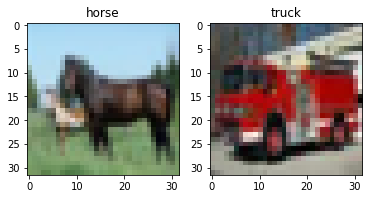

In [ ]:
def visualize_image(train_idx: int, test_idx: int):
    """
    Function to visualize the images and labels given an sample number as index in train and test set
    
    Parameters:
    -----------
    train_idx: integer
    test_idx: integer
        
    """
    img1, label1 = trainset[train_idx] # normalized image in range (-1, 1)
    img1 = img1 / 2 + 0.5     # unnormalize image in range (0, 1)
    npimg1 = img1.numpy()
    img2, label2 = testset[test_idx]
    img2 = img2 / 2 + 0.5     # unnormalize
    npimg2 = img2.numpy()
    print('Shape of single image: ', img1.shape)
    plt.subplot(121)
    plt.imshow(np.transpose(npimg1, (1, 2, 0)))
    plt.title(CLASSES[label1])
    plt.subplot(122)
    plt.imshow(np.transpose(npimg2, (1, 2, 0)))
    plt.title(CLASSES[label2])
    plt.show()

if VISUALIZE:
    visualize_image(12, 23)
    

                      

In [ ]:
if torch.cuda.is_available():
    device_under_use = torch.device("cuda")
else:
    device_under_use = torch.device("cpu")
print(device_under_use)

cpu


In [ ]:
# Get PyTorch train and validation samplers
def split(dataset: torch.utils.data.Dataset, 
          train_data_ratio: float = 0.7,
          shuffle: bool = True,
          random_seed: int = 0,
         ) -> typing.Tuple[SubsetRandomSampler, SubsetRandomSampler]:
    """
    Function to split train set into train & valid SubsetRandomSamplers.
    This doesnot return in 2 seperate torch.utils.data.Dataset() classes but returns 2 different Samplers.
    
    Parameters:
    -----------
    dataset: torch.utils.data.Dataset()
        Train set of CIFAR 10
    train_data_ratio: float
        Train data ratio, should be <1.0
    shuffle: bool
        Whether the output samplers will be shuffled or not.
    random_seed: int
        For setting np.random.seed() for shuffling (if shuffle==True)
    
    Return:
    -------
    train_sampler, valid_sampler, test_sampler: Tuple[SubsetRandomSampler, SubsetRandomSampler, SubsetRandomSampler]
        Individual samplers for train, validation and test data.
    """

    num_data = len(dataset)
    indices = list(range(num_data))
    split_train = int(np.floor(train_data_ratio * num_data))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx, valid_idx= (
        indices[:split_train],
        indices[split_train:],
    )

    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    return train_sampler, valid_sampler

In [ ]:
def get_train_valid_test_loader(train_dataset: torch.utils.data.Dataset,
                                test_dataset: torch.utils.data.Dataset,
                                train_batch_size: int = 8,
                                val_batch_size: int = 8,
                                test_batch_size: int = 8,
                                random_seed: int = 0,
                                shuffle: bool = True,
                                num_workers: int = 0,
                                pin_memory: bool = True,
                               ) -> typing.Tuple[torch.utils.data.DataLoader,
                                                 torch.utils.data.DataLoader, 
                                                 torch.utils.data.DataLoader,
                                                ]:
    """
    Parameters:
    -----------
    train_dataset: torch.utils.data.Dataset()
        Train set
    test_dataset: torch.utils.data.Dataset()
        Train set
    batch_size: int
        Batch size for training. The loader provides batch_size number of samples for each training time step.
    random_seed: int
        For setting np.random.seed() for shuffling (if shuffle==True)
    shuffle: bool
        If set true, the data is shuffled before sampling
    num_workers:: int
        How many subprocesses to use for data loading. 0 means the data will be loaded in the main process only.
    pin_memory: bool
        Decided whether data loader should copy the Tensors into CUDA pinned memory.
    
    Return:
    -------
    train_loader, valid_loader, test_loader:
        Tuple[torch.utils.data.DataLoader, torch.utils.data.DataLoader, torch.utils.data.DataLoader]
        DataLoader for each sets of data.
    """

    
    # get train, validation and test samplers
    train_sampler, valid_sampler= split(
        train_dataset,
        train_data_ratio=0.7,
        shuffle=shuffle,
        random_seed=random_seed,
    )
    
    # load dataset
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=train_batch_size,
        sampler=train_sampler,
        num_workers=num_workers,
        pin_memory=pin_memory,
    )

    valid_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=val_batch_size,
        sampler=valid_sampler,
        num_workers=num_workers,
        pin_memory=pin_memory,
    )

    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=test_batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=False,
    )

    return train_loader, valid_loader, test_loader

In [ ]:
def accuracy_metric(Y: np.ndarray,
                    predictions: np.ndarray,
                   ) -> float:
    """
    Parameters:
    -----------
    Y: np.ndarray
        True labels in the test set
    predictions: np.ndarray
        Predictions on MNIST test set using the trained 2-layer NN
        
    Return:
    -------
    accuracy: float
        Accuracy metric on the Y and predictions provided to the function 
    
    """
    correct = 0
    for i in range(len(Y)):
        if Y[i] == predictions[i]:
            correct += 1
    accuracy = correct / float(len(Y)) * 100.0
    return accuracy

def metrics(Y: np.ndarray,
            predictions: np.ndarray,
            print_metrics: bool = False) -> typing.Tuple:
    """
    Calculates the accuracy and prints the confusion matrix for the true labels and predictions provided
    Parameters:
    -----------
    Y: np.ndarray
        True labels in the test set
    predictions: np.ndarray
        Predictions on MNIST test set using the trained 2-layer NN
    print_metrics: bool
        Flag to allow printing of the metrics calculated
    
    Return:
    -------
    accuracy: float
        Accuracy for the labels and predictions provided
    df_confusion: pandas dataframe
        Confusion matrix for the labels and predictions provided
        
    """
    accuracy = accuracy_metric(Y, predictions)
    df_confusion = pd.crosstab(Y, predictions, rownames=['Actual'], colnames=['Predicted'], margins=True)
    
    if print_metrics:
        print("Accuracy: ", accuracy)
        print("Confusion matrix: \n", df_confusion)
        
    return accuracy, df_confusion


In [ ]:
def plot_training_graph(train_data: typing.List, 
                        val_data: typing.List,
                        label: bool):
    
    """
    Visualize the training/validation loss/accuracy of the model
    
    Parameters:
    -----------
    train_data: typing.List
        Train loss/accuracy per epoch
    val_data: typing.List,
        Validation loss/accuracy per epoch
    label: bool
        Flag stating whether loss/accuracy
    
    """
    if label == 'accuracy':
        train_label = 'Training accuracy'
        val_label = 'Validation accuracy'
        x_label = 'Epoch'
        y_label = 'Accuracy'
        title = 'Epoch vs Accuracy'
    else:
        train_label = 'Training loss'
        val_label = 'Validation loss'
        x_label = 'Epoch'
        y_label = 'Loss'
        title = 'Epoch vs Loss'
    fig = plt.figure(figsize=(12,12))
    plt.plot(train_data, c='k', label=train_label)
    plt.plot(val_data, c='m', label=val_label)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.grid()
    plt.show()
    return fig

In [ ]:
def get_gradients(named_parameters: typing.Generator) -> typing.List:
    
    """
    Parameters:
    -----------
    named_parameters: typing.Generator 
        model layer names and tensor value
    
    Return:
    -------
    norm_grads: typing.List
        List of gradient norms for all layers in the model named parameters
    
    """
    norm_grads = []
    layers = []
    for name, tensor_value in named_parameters:
        
        if tensor_value.requires_grad:
            layers.append(name)
            norm_grads.append(tensor_value.grad.abs().norm().item())
            
    return norm_grads

In [ ]:
def plot_norm_grads(named_parameters: typing.Generator, 
                    norm_grads: typing.List):
    
    """
    Parameters:
    -----------
    named_parameters: typing.Generator 
        model layer names and tensor value
    
    norm_grads: typing.List
        List of gradient norms for all layers in the model named parameters
    
    """
    norm_grads_array = np.array(norm_grads)
    
    plots_per_row = 2
    rows = int(norm_grads_array.shape[1] / plots_per_row) 
    columns = min(norm_grads_array.shape[1], plots_per_row)
    remaining = (norm_grads_array.shape[1] - (rows * columns))
    if remaining:
        rows = rows + 1
    
    if rows > 5:
        fig, axs = plt.subplots(rows, columns, figsize=(35, 12), facecolor='w', edgecolor='k')
    else:
        fig, axs = plt.subplots(rows, columns, figsize=(20, 12), facecolor='w', edgecolor='k')
    fig.suptitle("Layer-wise gradient norm")
    fig.subplots_adjust(left=0.125, bottom=0.2, right=0.9, top=0.9, wspace=0.2, hspace=1.3)
    
    layers = []
    for name, tensor_value in named_parameters:
        if tensor_value.requires_grad:
            layers.append(name)

    axs = axs.flatten()
    for i, ax in enumerate(axs):
        ax.plot(norm_grads_array[:, i])
        ax.set_title(layers[i])
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Gradient norm')
        
    plt.show()
    return fig

In [ ]:
def get_optimizer(model: torch.nn.Module,
                  optimizer_class: str = "SGD", 
                  learning_rate: float = 0.01, 
                  weight_decay: float = 0,) -> torch.optim:
    
    """
    Provides an optimizer for training the model depending on the string passed
    Parameters:
    -----------
    model: torch.nn
        Classifier model
    learning_rate: float
        Learning rate for weight update
    optimizer_class: str
        Optimizer used in training
    weight_decay: str
        Weight decay for the parameters during the optimization process
    Return:
    -------
    optimizer: torch.optim
        Optimizer Pytorch
    
    """
    
    if optimizer_class == "SGD":
        return torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif optimizer_class == "ADAM":
        return torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif optimizer_class == "ADAGRAD":
        return torch.optim.Adagrad(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif optimizer_class == "ADADELTA":
        return torch.optim.Adadelta(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif optimizer_class == "RMSPROP":
        return torch.optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        
    

In [ ]:
def softmax(x: torch.Tensor) -> torch.Tensor:
    
    """
    Parameters:
    -----------
    x: torch.Tensor
        Input tensor to perform softmax
        
    Return:
    -------
    Softmax(x)
    """
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def nl(input_: torch.Tensor, 
       target: torch.Tensor,
      ) -> torch.Tensor: 
    """
    Parameters:
    -----------
    input_: torch.Tensor
        Input tensor for nl: SOFTMAX(PREDICTIONS)
    target: torch.Tensor
        Target tensor for CE: NL(input_, target)
    
    Return: 
    -------
    loss: torch.Tensor
        NL(input_, target)
    """
    return -input_[range(target.shape[0]), target].mean()

def ce_loss(predictions: torch.Tensor, 
            targets: torch.Tensor,
           ) -> torch.Tensor:
    """
    Parameters:
    -----------
    predictions: torch.Tensor
        Input tensor are model predictions
    targets: torch.Tensor
        Ground truth labels
    
    Return: 
    -------
    loss: torch.Tensor
        NL(SOFTMAX(predictions), targets)
    """
    soft_out = softmax(predictions)
    loss = nl(soft_out, targets)
    return loss

def hinge_loss_non_vector(predictions: torch.Tensor,
                          targets: torch.Tensor,
                         ) -> torch.Tensor:
    """
    Parameters:
    -----------
    predictions: torch.Tensor
        Input tensor are model predictions
    targets: torch.Tensor
        Ground truth labels
    
    Return: 
    -------
    loss: torch.Tensor
        mean(sum_j!=y(max(0, s_i - s_j + 1)))
    """
    loss_per_image = []
    for i in zip(predictions, targets):
        sum_ = [max(0, i[0][j] - i[0][i[1].item()].item() + 1) for j in range(len(i[0])) if j != i[1].item()]  
        loss_per_image.append(sum(sum_))
    loss = sum(loss_per_image) / len(loss_per_image)
    return loss

def hinge_loss_vectorized(predictions: torch.Tensor, 
                          targets: torch.Tensor,
                         ) -> torch.Tensor:
    """
    Parameters:
    -----------
    predictions: torch.Tensor
        Input tensor are model predictions
    targets: torch.Tensor
        Ground truth labels
    
    Return: 
    -------
    loss: torch.Tensor
        mean(sum_j!=y(max(0, s_i - s_j + 1)))
    """
    loss = 0
    for pred, y in zip(predictions, targets): 
        margin = torch.relu(pred - pred[y] + 1)
        margin[y] = 0
        loss_i = torch.sum(margin)
        loss = loss + (loss_i)
    mean_loss = loss / len(predictions)
    return mean_loss

def get_criterion(criterion_class: str):
    
    """
    Parameters:
    -----------
    criterion_class: str 
        Criterion required for training as string
        
    Return:
    -------
    Criterion: Union[torch.nn, typing.Callable]
        Loss function for training
    
    """
    
    if criterion_class == "PyTorch Cross-Entropy":
        return nn.CrossEntropyLoss().to(device_under_use)
    
    elif criterion_class == "Manual Cross-Entropy":
        return ce_loss
    
    elif criterion_class == "Manual SVM-Hinge":
        return hinge_loss_vectorized
    
    

In [ ]:
def get_regularizer(model: torch.nn, 
                    regularization_level: str,
                   ) -> torch.Tensor:
    """
    Parameters:
    -----------
    model: torch.nn
        Classifier model
    regularization_level: str
        String for L1 or L2 regularization
        
    Return:
    -------
    l_reg: torch.Tensor
        Either L1 or L2 regularized value for the model parameters provided
    
    """
    if regularization_level == "L1":
        norm_ = 1
    elif regularization_level == "L2":
        norm_ = 2
    l_reg = None
    for W in model.parameters():
        if l_reg is None:
            l_reg = W.norm(norm_)
        else:
            l_reg = l_reg + W.norm(norm_)
    return l_reg

In [ ]:
def get_activation(activation_function: str):
    
    """
    Provides an activation function to develop the model depending on the string passed
    
    Parameters:
    -----------
    activation_function: str
        Activation function as a string value
    
    Return:
    -------
    activation: torch.nn
        Activation function used in all the layers of the model (except the final layer)
    """
    if activation_function == "RELU":
        activation = nn.ReLU()
    elif activation_function == "SIGMOID":
        activation = nn.Sigmoid()
    elif activation_function == "SOFTMAX":
        activation = nn.Softmax(dim=1)
    elif activation_function == "TANH":
        activation = nn.Tanh()   
        
    return activation
    

In [ ]:
def validation(valid_loader: torch.utils.data.DataLoader, 
               model: torch.nn,
                criterion: typing.Union[torch.nn.CrossEntropyLoss, typing.Callable],
               regularization_level: str,
               regularization_rate: str,
              ) -> typing.Tuple:
    
    """
    Validation module
    
    Parameters:
    -----------
    valid_loader: torch.utils.data.DataLoader
        Validation data loader
    model: torch.nn
        Model
    regularization_level: str
        String for L1 or L2 regularization
    regularization_rate: float
        Lambda value for regularization
    criterion_class: typing.Union[torch.nn.CrossEntropyLoss, typing.Callable]
        Loss function used in the classifer training
    
    Return:
    -------
    avg_val_loss: float
        Validation loss for 1 full pass of the validation data
        
    avg_val_accuracy: float
        Validation accuracy for 1 full pass of the validation data
    
    """
    
    model.train(False)
    
    valid_len = len(valid_loader.batch_sampler)
    av_loss = 0
    av_accuracy = 0
    y_pred = []
    y_true = []
    
    for images, labels in valid_loader:
    
        images = images.to(device_under_use)
        labels = labels.to(device_under_use)
        
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        weight_norm = get_regularizer(model, regularization_level)
        loss = loss + regularization_rate * weight_norm
        av_loss += loss.detach().item()
        
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.tolist())
        
        labels_list = labels.tolist()
        y_true.extend(labels_list)
        
    accuracy, df_confusion = metrics(np.array(y_true), np.array(y_pred))
    
    avg_val_loss = av_loss / valid_len
#     avg_val_accuracy = av_accuracy / valid_len
    
    return avg_val_loss, accuracy
    

In [ ]:
def evaluation(test_loader:  torch.utils.data.DataLoader,
               model: torch.nn,
                criterion: typing.Union[torch.nn.CrossEntropyLoss, typing.Callable],
              ) -> typing.Tuple:
    
    """
    Testing module
    
    Parameters:
    -----------
    test_loader:  torch.utils.data.DataLoader
        Test data loader
    model: torch.nn
        Model
    criterion_class: typing.Union[torch.nn.CrossEntropyLoss, typing.Callable]
        Loss function used in the classifer training
    
    
    Return:
    -------
    avg_test_loss: float
        Average loss for the test set
    accuracy: float
        Accuracy for the labels and predictions provided
    df_confusion: pandas dataframe
        Confusion matrix for the labels and predictions provided
        
    """
    
    model.eval()
    
    test_len = len(test_loader.batch_sampler)
    print('Size of test data: ', test_len)
    
    test_loss = 0
    confusion_matrix = np.zeros((11, 11))
    accuracy_list = []
    y_pred = []
    y_true = []
    
    for images, labels in test_loader:
    
        images = images.to(device_under_use)
        labels = labels.to(device_under_use)
        
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        test_loss += loss.detach().item()
        
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.tolist())
        
        labels_list = labels.tolist()
        y_true.extend(labels_list)
        
    accuracy, df_confusion = metrics(np.array(y_true), np.array(y_pred), True)
    avg_test_loss = test_loss / test_len
    return avg_test_loss, accuracy, df_confusion

In [ ]:
def plot_to_tensorboard(writer, tag, fig, step):
    """
    Takes a matplotlib figure handle and converts it using
    canvas and string-casts to a numpy array that can be
    visualized in TensorBoard using the add_image function

    Parameters:
        writer (tensorboard.SummaryWriter): TensorBoard SummaryWriter instance.
        fig (matplotlib.pyplot.fig): Matplotlib figure handle.
        step (int): counter usually specifying steps/epochs/time.
    """

    # Draw figure on canvas
    fig.canvas.draw()

    # Convert the figure to numpy array, read the pixel values and reshape the array
    img = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
    img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    
    # Normalize into 0-1 range for TensorBoard(X). Swap axes for newer versions where API expects colors in first dim
    img = img / 255.0
    img = np.swapaxes(img, 0, 2)
    img = np.swapaxes(img, 1, 2)
    
    # Add figure in numpy "image" to TensorBoard writer
    writer.add_image(tag, img, 0)
    plt.close(fig)

In [ ]:
class Hybrid(nn.Module):
    def __init__(self,channel, kernel_size=2):
        super(Hybrid, self).__init__()
        self.kernel_size = kernel_size
        self.cnn= nn.Conv2d( channel*2,channel, 1)
    def forward(self, x):
        max_ = nn.MaxPool2d(kernel_size=self.kernel_size)(x)
        avg_ = nn.AvgPool2d(kernel_size=self.kernel_size)(x)
        cat = torch.cat((max_, avg_), 1)
        return self.cnn(cat)
    


def get_pooling(pooling_type: str,inCs=[]):
    
    """
    Provides a pooling layer to develop the model depending on the string passed
    
    Parameters:
    -----------
    pooling_type: str
        Pooling operation type as a string value
    
    Return:
    -------
    pooling: torch.nn
        Pooling layer used in the model
    """
    
    if pooling_type == "MAX":
        pooling = nn.MaxPool2d(kernel_size=2)
        return [pooling]*len(inCs)
    elif pooling_type == "AVERAGE":
        pooling = nn.AvgPool2d(kernel_size=2)
        return [pooling]*len(inCs)
    elif pooling_type == "HYBRID":
        return [Hybrid(i,kernel_size=2) for i in inCs]
    else:
        raise BaseException("Wrong pooling type")

class CNNModel(nn.Module):
    def __init__(self, activation_function, pooling_type):
        super(CNNModel, self).__init__()

        midChannels = [16,32]
        
        activation = torch.nn.ReLU()#get_activation(activation_function)
        
        pooling_layer = get_pooling(pooling_type,midChannels)
        
        
        # Convolution 1
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=midChannels[0], kernel_size=5, stride=1, padding=0)
        self.activation1 = activation

        # Max pool 1
        self.pool1 = pooling_layer[0]
        print(self.pool1)

        # Convolution 2
        self.cnn2 = nn.Conv2d(in_channels=midChannels[0], out_channels=midChannels[1], kernel_size=5, stride=1, padding=0)
        self.activation2 = activation

        # Max pool 2
        self.pool2 = pooling_layer[1]

        # Fully connected 1 (readout)
        self.fc1 = nn.Linear(midChannels[1] * 5 * 5, 10)

    def forward(self, x):
        # x =  torch.Size([100, 1, 28, 28])
        # Convolution 1
        out = self.cnn1(x) #torch.Size([100, 16, 24, 24])
        out = self.activation1(out) #torch.Size([100, 16, 24, 24])

        # Max pool 1
        out = self.pool1(out) #torch.Size([100, 16, 12, 12])

        # Convolution 2
        out = self.cnn2(out) #torch.Size([100, 32, 8, 8])
        out = self.activation2(out) #torch.Size([100, 32, 8, 8])

        # Max pool 2
        out = self.pool2(out) #torch.Size([100, 32, 4, 4])

        out = out.view(out.size(0), -1)   #torch.Size([100, 512])

        # Linear function (readout)
        out = self.fc1(out)

        return out

def check_model():
    model = CNNModel(activation_function="RELU", pooling_type="HYBRID").to(device_under_use)
    
    #You should be able to see params:
    
    for p,c in model.named_parameters():
        print(p)
    print("------------------",end='\n\n')
    
    summary(
        model,
        input_size=(3, 32, 32),
        batch_size=16,
        device = device_under_use.type
    )

check_model()


Hybrid(
  (cnn): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1))
)
cnn1.weight
cnn1.bias
pool1.cnn.weight
pool1.cnn.bias
cnn2.weight
cnn2.bias
pool2.cnn.weight
pool2.cnn.bias
fc1.weight
fc1.bias
------------------

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [16, 16, 28, 28]           1,216
              ReLU-2           [16, 16, 28, 28]               0
            Conv2d-3           [16, 16, 14, 14]             528
            Hybrid-4           [16, 16, 14, 14]               0
            Conv2d-5           [16, 32, 10, 10]          12,832
              ReLU-6           [16, 32, 10, 10]               0
            Conv2d-7             [16, 32, 5, 5]           2,080
            Hybrid-8             [16, 32, 5, 5]               0
            Linear-9                   [16, 10]           8,010
Total params: 24,666
Trainable params: 24,666
Non-trainable params: 0
--------

In [ ]:
def trainer(train_loader: torch.utils.data.DataLoader,
            valid_loader: torch.utils.data.DataLoader,
            model: torch.nn,
            num_epochs: int,
            learning_rate: float,
            patience: int,
            optimizer: torch.optim,
            criterion: typing.Union[torch.nn.CrossEntropyLoss, typing.Callable],
            writer: torch.utils.tensorboard.SummaryWriter,
            early_stopping: bool = True,
            regularization_level: str = "L2",
            regularization_rate: float = 0.001,
            plot_gradients: bool = True,
            additional_scalar_identifier: str = '',
           ) -> typing.Tuple:
    
    """
    Parameters:
    -----------
    train_loader: torch.utils.data.DataLoader
        Train data loader
    valid_loader: torch.utils.data.DataLoader
        Validation data loader
    model: torch.nn
        Classifier model
    num_epochs: int
        Maximum epoch limit
    learning_rate: float
        Learning rate for weight update
    patience: int
        Patience to trigger early stopping    
    plot_gradients: bool
        Flag to plot all the layer-wise weight gradients
    optimizer_class: str
        Optimizer used in training
    regularization_level: str
        String for L1 or L2 regularization
    regularization_rate: float
        Lambda value for regularization
    criterion_class: typing.Union[torch.nn.CrossEntropyLoss, typing.Callable]
        Loss function used in the classifer training
    early_stopping: bool
        Whether early stopping is activated or not
    writer: torch.utils.tensorboard.SummaryWriter
        Summary writer for tensorboard
    additional_scalar_identifier: str
        String to differentiate different experimental parameters in the tensorboard graph names
        
    Return:
    -------
    best_model: torch.nn
        Best model from training depending on the validation loss
    train_costs_per_epoch: List
        List containing loss on training data for each epoch
    val_costs_per_epoch: List
        List containing loss on validation data for each epoch
    train_accuracy_per_epoch: List
        List containing accuracy on training data for each epoch
    val_accuracy_per_epoch: List
        List containing loss on validation data for each epoch
    fig_gradients: matplotlib.pyplot
        Gradients norm across model parameters
    Epoch: int 
        Num epochs ran
    
    """
    
    patience_count = patience    
    best_validation_loss = np.inf
    train_costs_per_epoch = []
    val_costs_per_epoch = []
    best_model = model
    norm_grads = []
    train_accuracy_per_epoch = []
    val_accuracy_per_epoch = []
    
    for epoch in range(num_epochs):

        running_train_loss = []
        running_norm_grads = []
        running_train_accuracy = []
        y_pred = []
        y_true = []
        
        model.train(True)

        for images, labels in train_loader:

            images = images.to(device_under_use)
            labels = labels.to(device_under_use)
            
            optimizer.zero_grad()

            outputs = model(images)

            loss = criterion(outputs, labels)

            weight_norm = get_regularizer(model, regularization_level)
            loss = loss + regularization_rate * weight_norm
            running_train_loss.append(loss.detach().item())
            loss.backward()
            running_norm_grads.append(get_gradients(model.named_parameters()))
            optimizer.step()
            
            _, predicted = torch.max(outputs.data, 1)
            y_pred.extend(predicted.tolist())
        
            labels_list = labels.tolist()
            y_true.extend(labels_list)
        
        accuracy, df_confusion = metrics(np.array(y_true), np.array(y_pred))
        running_train_accuracy.append(accuracy)

        avg_train_loss = sum(running_train_loss) / len(running_train_loss)
        train_costs_per_epoch.append(avg_train_loss)

        avg_val_loss, avg_val_accuracy = validation(valid_loader, 
                                                    model, 
                                                    criterion, 
                                                    regularization_level=regularization_level, 
                                                    regularization_rate=regularization_rate,
                                                   )
        val_costs_per_epoch.append(avg_val_loss)
        val_accuracy_per_epoch.append(avg_val_accuracy)
        
        norm_grads_avg = list(np.mean(np.array(running_norm_grads), axis=0))
        norm_grads.append(norm_grads_avg)
        
        avg_train_accuracy = sum(running_train_accuracy) / len(running_train_accuracy)
        train_accuracy_per_epoch.append(avg_train_accuracy)
    
        # Early stopping: Waits up to the 'patience' number of epochs for a better model
        # If a better model is not found for the 'patience' number of epochs then training stops
        # To avoid overfitting of the model to the train set

        writer.add_scalar("training/average_train_loss" + additional_scalar_identifier, avg_train_loss, epoch + 1)
        writer.add_scalar("validation/average_valid_loss" + additional_scalar_identifier, avg_val_loss, epoch + 1)
        writer.add_scalar("training/average_train_accuracy" + additional_scalar_identifier, avg_train_accuracy, epoch + 1)
        writer.add_scalar("validation/average_valid_accuracy" + additional_scalar_identifier, avg_val_accuracy, epoch + 1)
        
        if early_stopping:
            if avg_val_loss < best_validation_loss:
                best_validation_loss = avg_val_loss
                best_model = model
                patience_count = patience
                print("Better model found: Epoch: %i -- Train loss: %f -- Validation loss: %f"%(epoch + 1, avg_train_loss, avg_val_loss))
            else:
                patience_count = patience_count - 1
                print("No better model found: Epoch: %i -- Train loss: %f -- Validation loss: %f"%(epoch + 1, avg_train_loss, avg_val_loss))

            if patience_count == 0:
                print("Early stopping triggered: Epoch: %i -- Train loss: %f -- Validation loss: %f" %(epoch + 1, avg_train_loss, avg_val_loss))
                break 
        else:
            if avg_val_loss < best_validation_loss:
                best_validation_loss = avg_val_loss
                best_model = model
                print("Better model found: Epoch: %i -- Train loss: %f -- Validation loss: %f"%(epoch + 1, avg_train_loss, avg_val_loss))
            else:
                print("No better model found: Epoch: %i -- Train loss: %f -- Validation loss: %f"%(epoch + 1, avg_train_loss, avg_val_loss))
            
            
    fig_gradients = None
    if plot_gradients:
        fig_gradients = plot_norm_grads(model.named_parameters(), norm_grads)
        
    return best_model, train_costs_per_epoch, val_costs_per_epoch, train_accuracy_per_epoch, val_accuracy_per_epoch, fig_gradients, epoch + 1

In [ ]:
def get_model(model: str, activation_function: str, pooling_type: str):
    
    """
    Generates a model depending on the requirement of the user
    Parameters:
    -----------
    model: str
        Flag for model selection
        Returns the following models depending on the string
        CNN: a CNN model with 1 Fully conneted layer at the end.
        Full_CNN: a fully CNN model
        FCN: a simple CNN model but with 2 Fully connected layers at the end.
    activation_function: str
        Activation function
    pooling_type: str
        Pooling operation type as a string value
    
    Return:
    -------
    model: torch.nn
        Returns the following models
        CNN: a CNN model with 1 Fully conneted layer at the end.
        Full_CNN: a fully CNN model
        FCN: a simple CNN model but with 2 Fully connected layers at the end.
    
    """
    
    if model == "CNN":
        return CNNModel(activation_function=activation_function, pooling_type=pooling_type).to(device_under_use)
    
    elif model == "Full_CNN":
        return Model_CNN(activation_function=activation_function, pooling_type=pooling_type).to(device_under_use)
    
    elif model == "FCN":
        return Model_FCN(activation_function=activation_function, pooling_type=pooling_type).to(device_under_use)
    
    elif model == "CNN_attention":
        return CNN_attention(activation_function=activation_function, pooling_type=pooling_type).to(device_under_use)

In [ ]:
def CIFAR10_classifier(learning_rate: float,
                       train_batch_size: int,
                       patience: int,
                       activation_function: str,
                       num_epochs: int,
                       optimizer_class: str, 
                       pooling_type: str = "MAX",
                       experiment_name: str = "trial_runs",
                       regularization_level: str = "L2",
                       weight_decay: float = 0.0,
                       criterion_class: str = "PyTorch Cross-Entropy",
                       early_stopping: bool = True,
                       close_writer: bool = False,
                       additional_scalar_identifier: str = '_',
                       plot_gradients=False,
                       model_type="CNN",
                      ) -> typing.Tuple:

                          
    """
    Function performing the classification on CIFAR10
    
    Parameters:
    -----------
    learning_rate: float
        Learning rate for weight update
    train_batch_size: int
        Batch size of train loader
    patience: int
        Patience to trigger early stopping   
    activation_function: str
        Activation function
    num_epochs: int
        Maximum epoch limit
    optimizer_class: str
        Optimizer used in training
    pooling_type: str
        Pooling operation type as a string value
    regularization_level: str
        String for L1 or L2 regularization
    weight_decay: float
        Weight decay value for regulariation
    criterion_class: str
        Loss function used in the classifer training
    early_stopping: bool
        Whether early stopping is activated or not
    close_writer: bool
        Flag to close the tensorboard summary writer
    additional_scalar_identifier: str
        String to differentiate different experimental parameters in the tensorboard graph names
    plot_gradients: bool
        Flag to plot the gradient norm
        
    Return:
    -------
    best_model: torch.nn
        Best model from training depending on the validation loss
    accuracy: float
        Accuracy for the labels and predictions provided
    writer: tensorboard.summarywriter
        Summary writer for tensorboard
    
    """
    
    # Hyperparameters
    learning_rate = learning_rate
    train_batch_size = train_batch_size
    patience = patience
    activation_function = activation_function
    num_epochs = num_epochs
    
    # Fixed parameters
    val_batch_size = 100
    test_batch_size = 8
    input_dim = (3, 32, 32)
    output_dim = 10
    
    print("\n")
    print("##### Statistics of the run #####")
    print("Learning rate: ", learning_rate)
    print("Batch size for training: ", train_batch_size)
    print("Patience for early stopping: ", patience)
    print("Activation function: ", activation_function)
    print("Num epochs: ", num_epochs)
    print("Optimizer class: ", optimizer_class)
    print("Regularizer level: ", regularization_level)
    print("Weight decay: ", weight_decay)
    print("Criterion: ", criterion_class)
    
    train_loader, valid_loader, test_loader = get_train_valid_test_loader(train_dataset=trainset,
                                                                          test_dataset=testset,
                                                                          train_batch_size=train_batch_size,
                                                                          val_batch_size=val_batch_size,
                                                                          test_batch_size=test_batch_size,
                                                                          random_seed=0,
                                                                          shuffle=True,
                                                                          num_workers=0,
                                                                          pin_memory=True,
                                                                         )
    print("Number of train batches: ", len(train_loader.batch_sampler))
    print("Number of validation batches: ", len(valid_loader.batch_sampler))
    print("Number of test batches: ", len(test_loader.batch_sampler))
   
    model = get_model(model_type, activation_function, pooling_type)
    print("Model summary:")
    summary(
        model,
        input_size=input_dim,
        batch_size=16,
        device=device_under_use.type,
    )    
    writer = SummaryWriter("runs/" + experiment_name)
    writer.add_graph(model, torch.randn((1, ) + input_dim))

    optimizer = get_optimizer(model=model, 
                              optimizer_class=optimizer_class, 
                              learning_rate=learning_rate, 
                              weight_decay=weight_decay,
                             )
    
    criterion = get_criterion(criterion_class)
    print("\n") 
    print("##### Training module #####")
    best_model, train_costs_per_epoch, val_costs_per_epoch, \
    train_accuracy_per_epoch, val_accuracy_per_epoch, fig_gradients, final_epoch = trainer(train_loader=train_loader,
                                                               valid_loader=valid_loader,
                                                               model=model,
                                                               num_epochs=num_epochs,
                                                               learning_rate=learning_rate,
                                                               patience=patience,
                                                               optimizer=optimizer,
                                                               criterion=criterion,
                                                               regularization_level=regularization_level,
                                                               writer=writer,
                                                               early_stopping=early_stopping,
                                                               additional_scalar_identifier=additional_scalar_identifier,
                                                               plot_gradients=plot_gradients,
                                                               )
    fig_costs = plot_training_graph(train_costs_per_epoch, val_costs_per_epoch, 'loss')
    fig_accuracy = plot_training_graph(train_accuracy_per_epoch, val_accuracy_per_epoch, 'accuracy')
    print("\n")
    print("##### Evaluation module #####")
    avg_test_loss, accuracy, df_confusion = evaluation(test_loader, best_model, criterion)
    print("\n")
    if plot_gradients:
        plot_to_tensorboard(writer, "Gradients" + additional_scalar_identifier, fig_gradients, 0)
    plot_to_tensorboard(writer, "Learning curve: loss" + additional_scalar_identifier, fig_costs, 0)
    plot_to_tensorboard(writer, "Learning curve: accuracy" + additional_scalar_identifier, fig_accuracy, 0)
    
    if close_writer:
        writer.close()
    return best_model, accuracy, writer


In [ ]:
# Fixing few parameter as constants for usage across the entire notebook for experiments like
LEARNING_RATE = 0.01
TRAIN_BATCH_SIZE = 100
PATIENCE = 3
ACTIVATION_FUNCTION = "RELU"
POOLING_TYPE = "HYBRID"
NUM_EPOCHS = 10
OPTIMIZER_CLASS = "SGD"
WEIGHT_DECAY = 0
REGULARIZATION_LEVEL = "L2"
CRITERION_CLASS = "PyTorch Cross-Entropy"
EARLY_STOPPING = False



##### Statistics of the run #####
Learning rate:  0.01
Batch size for training:  100
Patience for early stopping:  3
Activation function:  RELU
Num epochs:  10
Optimizer class:  SGD
Regularizer level:  L2
Weight decay:  0
Criterion:  PyTorch Cross-Entropy
Number of train batches:  350
Number of validation batches:  150
Number of test batches:  1250
Hybrid(
  (cnn): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1))
)
Model summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [16, 16, 28, 28]           1,216
              ReLU-2           [16, 16, 28, 28]               0
            Conv2d-3           [16, 16, 14, 14]             528
            Hybrid-4           [16, 16, 14, 14]               0
            Conv2d-5           [16, 32, 10, 10]          12,832
              ReLU-6           [16, 32, 10, 10]               0
            Conv2d-7             [16, 32, 5, 5]   

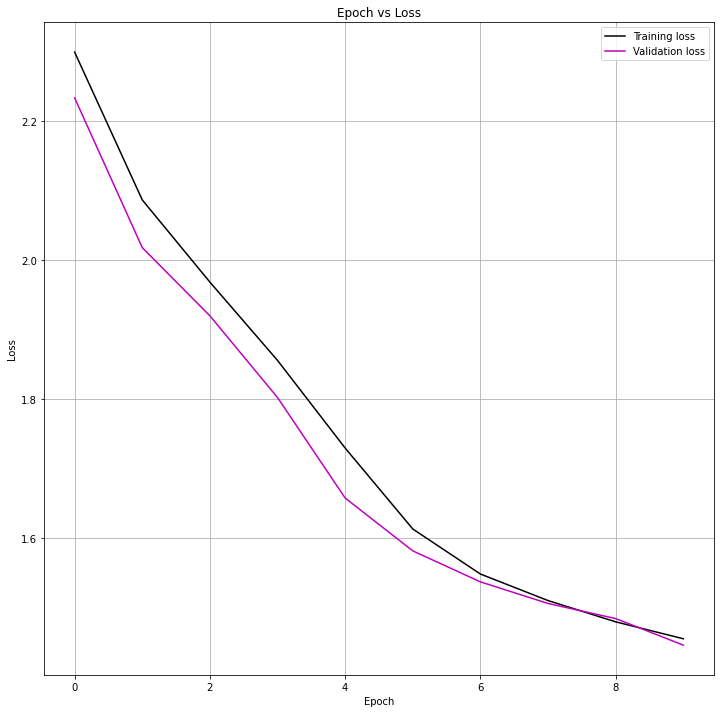

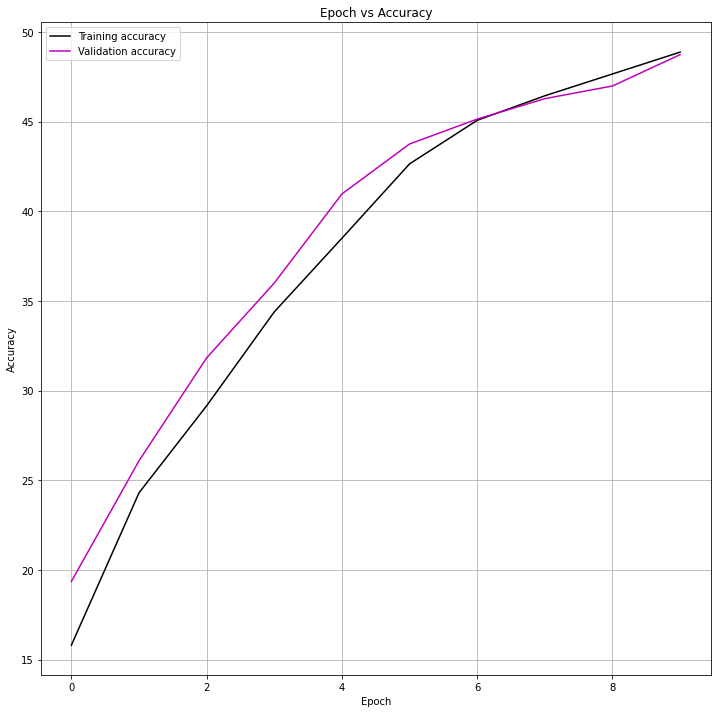



##### Evaluation module #####
Size of test data:  1250
Accuracy:  48.33
Confusion matrix: 
 Predicted    0     1    2    3    4    5     6     7     8     9    All
Actual                                                                 
0          458    49   59   25   29    7    28    34   236    75   1000
1           27   624    6   21    8    5    19    16    90   184   1000
2           75    21  272   80  194   63   145    92    27    31   1000
3           25    29   57  289   95  146   184   115    14    46   1000
4           33    21  101   59  385   37   176   147    23    18   1000
5           16    15   78  178   64  346    92   181    13    17   1000
6            7    14   45   65   76   19   687    50     9    28   1000
7           21     9   28   72   57   73    71   598    14    57   1000
8          112   100   16   25   12    4    11    23   633    64   1000
9           31   182   14   22    7   10    42    53    98   541   1000
All        805  1064  676  836  927  710  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


In [ ]:
model, accuracy, writer = CIFAR10_classifier(experiment_name="Final-run",
                                             learning_rate=LEARNING_RATE, 
                                             train_batch_size=TRAIN_BATCH_SIZE, 
                                             patience=PATIENCE, 
                                             activation_function=ACTIVATION_FUNCTION, 
                                             pooling_type=POOLING_TYPE,
                                             num_epochs=NUM_EPOCHS, 
                                             optimizer_class=OPTIMIZER_CLASS, 
                                             weight_decay=WEIGHT_DECAY,
                                             regularization_level=REGULARIZATION_LEVEL,
                                             criterion_class=CRITERION_CLASS,
                                             early_stopping=True,
                                             close_writer=True,
                                             additional_scalar_identifier="_Final_run"
                                            )

In [ ]:
# Save
torch.save(model, "model.th")

In [ ]:
# Reload
best_model = torch.load("model.th")
print(best_model)

CNNModel(
  (cnn1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (activation1): ReLU()
  (pool1): Hybrid(
    (cnn): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1))
  )
  (cnn2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (activation2): ReLU()
  (pool2): Hybrid(
    (cnn): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
  )
  (fc1): Linear(in_features=800, out_features=10, bias=True)
)


# Training CNN with the best hyperparameters

In [ ]:
# SMAC - Sequential Model-based Algorithm Configuration
import smac

# Import ConfigSpace and different types of parameters
from ConfigSpace.hyperparameters import CategoricalHyperparameter, \
    UniformFloatHyperparameter, UniformIntegerHyperparameter


from smac.configspace import ConfigurationSpace

from smac.facade.smac_hpo_facade import SMAC4HPO
from smac.scenario.scenario import Scenario
from smac.initial_design.default_configuration_design import DefaultConfiguration

In [ ]:
def define_search_space():
    """
    Build Configuration Space which defines all hyperparameters and their ranges
    
    Return:
    -------
    cs: ConfigurationSpace
        Configuration space with all hyperparameters of the classifier selected for HPO
    """
    
    cs = ConfigurationSpace()
    # constraining the parameter search space to curtail the train time
    # learning_rate = UniformFloatHyperparameter("learning_rate", 0.001, 0.01, default_value=0.001)
    # Keeping learning rate as a categorical parameter just to reduce the search space
    learning_rate = CategoricalHyperparameter("learning_rate", [0.001, 0.01, 0.1], default_value=0.001)
    #train_batch_size = CategoricalHyperparameter("train_batch_size", [8, 32, 100], default_value=8)
    activation_function = CategoricalHyperparameter("activation_function", ["RELU", "SIGMOID", "TANH"], default_value="RELU")
    pooling_type = CategoricalHyperparameter("pooling_type", ["MAX", "AVERAGE"], default_value="MAX")
    optimizer_class = CategoricalHyperparameter("optimizer_class", ["SGD", "ADAM", "ADAGRAD", "ADADELTA"], default_value="ADAM")
    #num_epochs = CategoricalHyperparameter("num_epochs", [10, 100, 150], default_value=100)
    cs.add_hyperparameters([learning_rate, activation_function, optimizer_class])
    
    return cs

def run_model_from_cfg(cfg):
    """
    Target algorithm wrapper evaluated by the SMAC as an objective function.
    In our case, the objective function is NN performing classification on CIFAR10 dataset
    
    Parameters:
    -----------
    cfg: Configuration
        One single configuration to be tested on the target algorithm by SMAC
        
    Return:
    -------
    accuracy: float
        Accuracy of the model on the CIFAR10 test set
        -ve value is returned as the result of evaluation because
        SMAC performs minimization of the cost function
    """
    print("##### Configuration #####")
    print(cfg)
    cfg = {k: cfg[k] for k in cfg if cfg[k]}
    cfg["patience"] = PATIENCE
    cfg["num_epochs"] = NUM_EPOCHS
    cfg["train_batch_size"] = TRAIN_BATCH_SIZE
    model, accuracy, writer = CIFAR10_classifier(**cfg)
    return -accuracy

INFO:smac.utils.io.cmd_reader.CMDReader:Output to smac3-output_2020-12-10_15:43:28_402862
INFO:smac.facade.smac_hpo_facade.SMAC4HPO:Optimizing a deterministic scenario for quality without a tuner timeout - will make SMAC deterministic and only evaluate one configuration per iteration!
INFO:smac.initial_design.default_configuration_design.DefaultConfiguration:Running initial design for 1 configurations
INFO:smac.facade.smac_hpo_facade.SMAC4HPO:<class 'smac.facade.smac_hpo_facade.SMAC4HPO'>
INFO:smac.optimizer.smbo.SMBO:Running initial design
INFO:smac.intensification.intensification.Intensifier:First run, no incumbent provided; challenger is assumed to be the incumbent


##### Configuration #####
Configuration:
  activation_function, Value: 'RELU'
  learning_rate, Value: 0.001
  optimizer_class, Value: 'ADAM'



##### Statistics of the run #####
Learning rate:  0.001
Batch size for training:  100
Patience for early stopping:  3
Activation function:  RELU
Num epochs:  10
Optimizer class:  ADAM
Regularizer level:  L2
Weight decay:  0.0
Criterion:  PyTorch Cross-Entropy
Number of train batches:  350
Number of validation batches:  150
Number of test batches:  1250
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Model summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [16, 16, 28, 28]           1,216
              ReLU-2           [16, 16, 28, 28]               0
         MaxPool2d-3           [16, 16, 14, 14]               0
            Conv2d-4           [16, 32, 10, 10]          12,832
              ReLU-5      

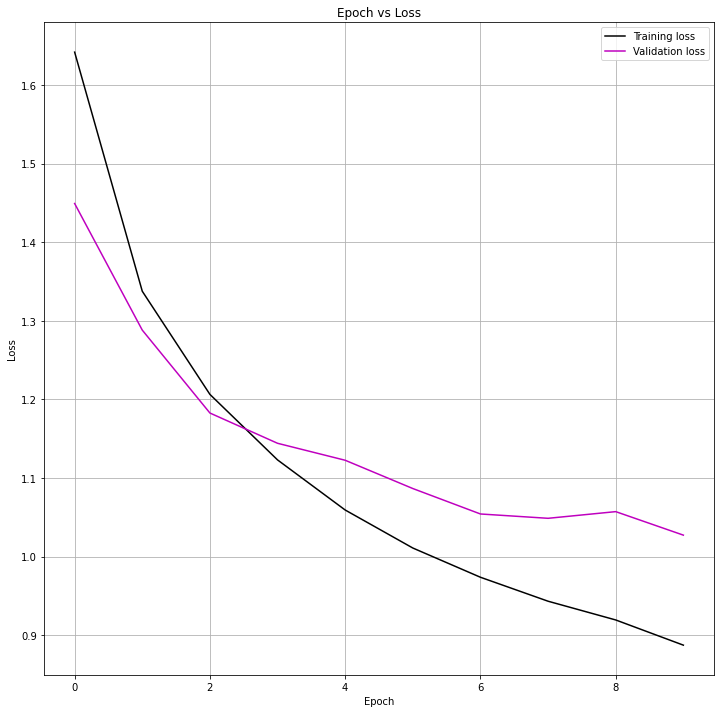

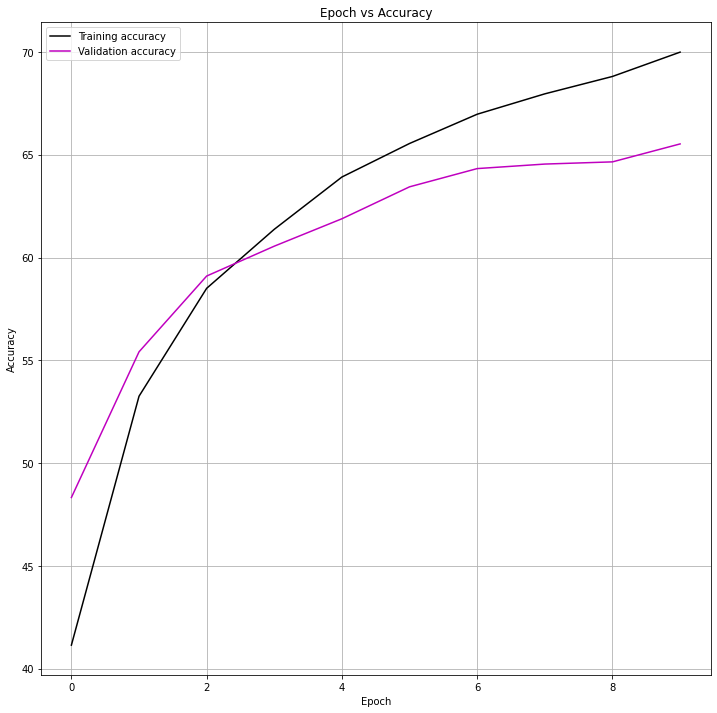



##### Evaluation module #####
Size of test data:  1250
Accuracy:  65.36999999999999
Confusion matrix: 
 Predicted    0    1    2    3    4    5    6     7     8    9    All
Actual                                                              
0          682   26   51   18   13    8    8    22   146   26   1000
1           30  754    8    7    4    8   11    21    56  101   1000
2           65    6  516   58  106   71   56    79    35    8   1000
3           32   13   77  430   72  181   58    86    36   15   1000
4           27    3   69   46  584   41   49   157    22    2   1000
5           11    5   68  165   50  531   28   115    21    6   1000
6            6    1   56   74   64   37  714    24    17    7   1000
7           17    1   27   37   46   57    4   790     5   16   1000
8           59   27   16    5    3    6    3    11   845   25   1000
9           34  114   14   16    6   12   11    35    67  691   1000
All        963  950  902  856  948  952  942  1340  1250  897  100

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
INFO:smac.intensification.intensification.Intensifier:First run, no incumbent provided; challenger is assumed to be the incumbent
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: -65.3700


##### Configuration #####
Configuration:
  activation_function, Value: 'RELU'
  learning_rate, Value: 0.001
  optimizer_class, Value: 'ADADELTA'



##### Statistics of the run #####
Learning rate:  0.001
Batch size for training:  100
Patience for early stopping:  3
Activation function:  RELU
Num epochs:  10
Optimizer class:  ADADELTA
Regularizer level:  L2
Weight decay:  0.0
Criterion:  PyTorch Cross-Entropy
Number of train batches:  350
Number of validation batches:  150
Number of test batches:  1250
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Model summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [16, 16, 28, 28]           1,216
              ReLU-2           [16, 16, 28, 28]               0
         MaxPool2d-3           [16, 16, 14, 14]               0
            Conv2d-4           [16, 32, 10, 10]          12,832
              ReLU

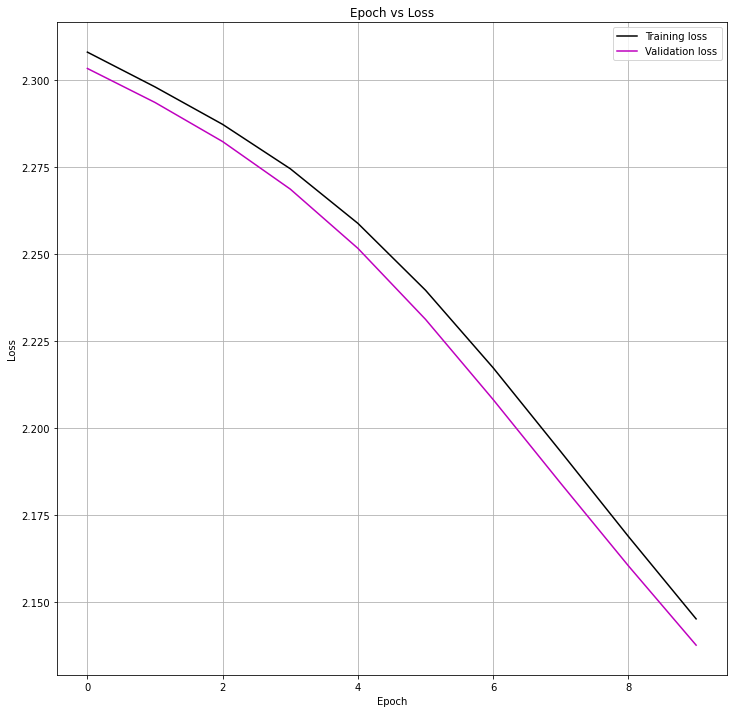

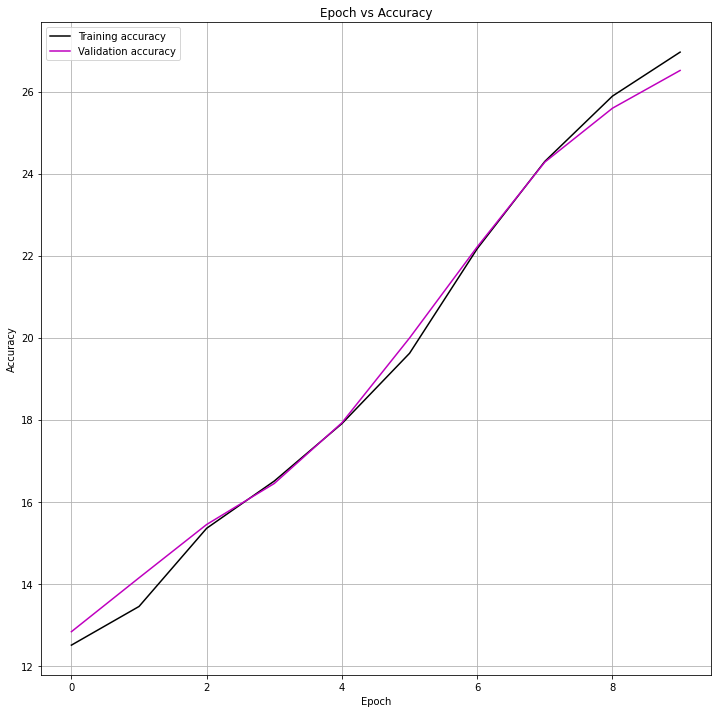



##### Evaluation module #####
Size of test data:  1250


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 540.021493 sec, available: 0.000010 sec)


Accuracy:  27.33
Confusion matrix: 
 Predicted     0     1   2   3  4    5     6     7     8     9    All
Actual                                                              
0           515    81   0   1  0    8    38    49   149   159   1000
1            86   316   0   3  0   22   105    47   147   274   1000
2           146   101   1   8  1   36   299   206    74   128   1000
3            90   120   2  15  0   83   257   250    75   108   1000
4            58    65   0   8  1   30   455   243    28   112   1000
5           117    96   1  11  1  121   189   236   123   105   1000
6            30    60   1   1  0   31   630   139    26    82   1000
7           104    80   2   4  0   35   135   388    56   196   1000
8           262    82   2   5  0   40    24    33   288   264   1000
9            87   171   1   2  0    3    86    62   130   458   1000
All        1495  1172  10  58  3  409  2218  1653  1096  1886  10000


##### Configuration #####
Configuration:
  activation_function, 

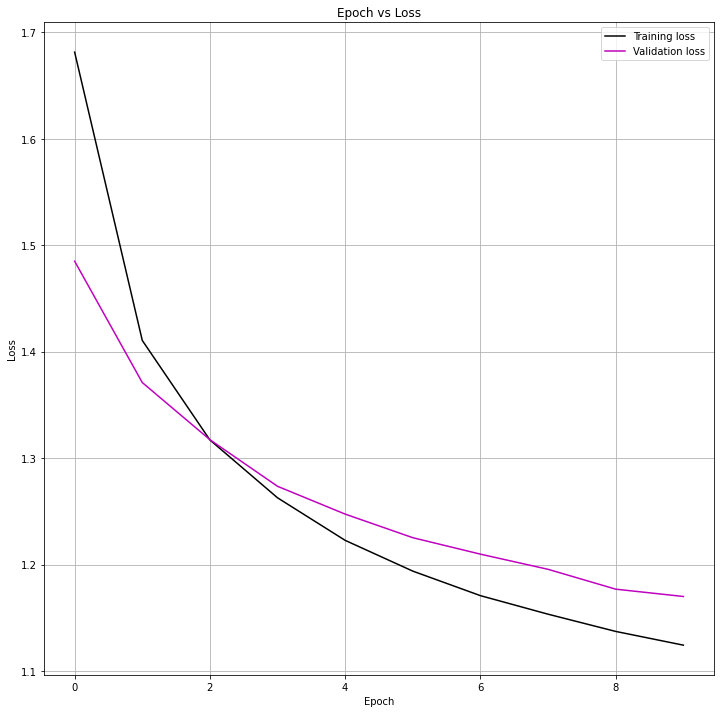

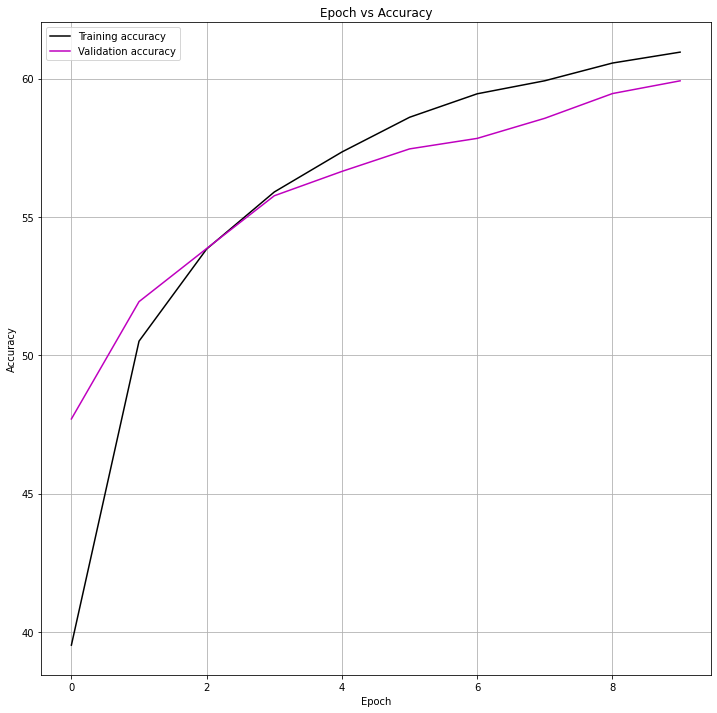



##### Evaluation module #####
Size of test data:  1250


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 270.957015 sec, available: 0.000010 sec)


Accuracy:  59.62
Confusion matrix: 
 Predicted    0     1    2    3    4     5     6    7     8    9    All
Actual                                                                
0          581    46   54   30   29    10    25   10   153   62   1000
1           22   750   12    7    9     5    12    8    54  121   1000
2           71    23  419   80  120    92   106   40    31   18   1000
3           17    17   75  347   87   223   125   48    30   31   1000
4           33    10  114   57  472    58   121  107    23    5   1000
5           10     7   82  160   48   543    61   62    16   11   1000
6            6    13   46   39   55    32   773   12    11   13   1000
7           18     5   35   45   63    96    33  665     8   32   1000
8           55    61   15   16   12    11     6   12   775   37   1000
9           39   174   13   16    6    11    23   29    52  637   1000
All        852  1106  865  797  901  1081  1285  993  1153  967  10000


##### Configuration #####
Configuratio

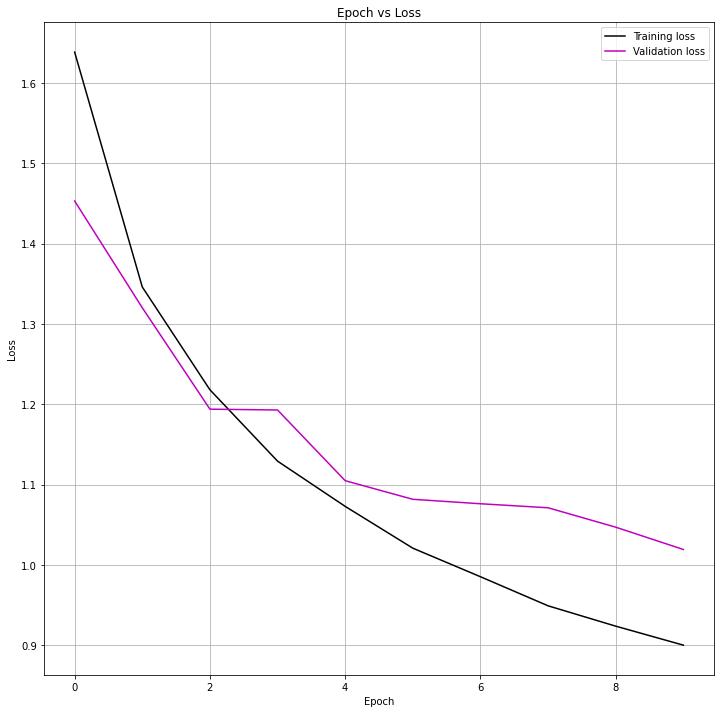

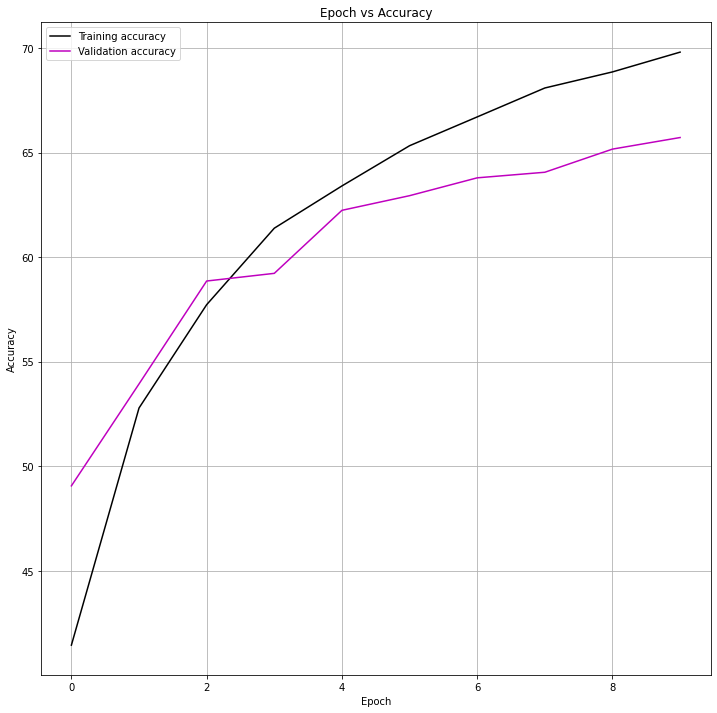



##### Evaluation module #####
Size of test data:  1250
Accuracy:  65.63
Confusion matrix: 
 Predicted     0    1     2    3    4     5     6    7     8     9    All
Actual                                                                  
0           720   21    63   27    9     4    12    7    88    49   1000
1            37  731    10    7    9     3    11    8    31   153   1000
2            79    7   536   46  103    81    70   32    24    22   1000
3            24    7    95  426   55   208    87   37    30    31   1000
4            32    1   103   63  576    48    55   93    21     8   1000
5            21    7    83  170   35   579    25   51    15    14   1000
6             8    4    44   65   59    33   761    5     9    12   1000
7            27    5    46   47   53    87     9  683     7    36   1000
8            97   40    21    8    8     6    11    4   762    43   1000
9            35   80    11   14    8     9    11   10    33   789   1000
All        1080  903  1012  87

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
INFO:smac.intensification.intensification.Intensifier:Challenger (-65.6300) is better than incumbent (-65.3700) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  activation_function : 'RELU' -> 'SIGMOID'
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 268.216524 sec, available: 0.000010 sec)


##### Configuration #####
Configuration:
  activation_function, Value: 'SIGMOID'
  learning_rate, Value: 0.1
  optimizer_class, Value: 'ADAM'



##### Statistics of the run #####
Learning rate:  0.1
Batch size for training:  100
Patience for early stopping:  3
Activation function:  SIGMOID
Num epochs:  10
Optimizer class:  ADAM
Regularizer level:  L2
Weight decay:  0.0
Criterion:  PyTorch Cross-Entropy
Number of train batches:  350
Number of validation batches:  150
Number of test batches:  1250
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Model summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [16, 16, 28, 28]           1,216
              ReLU-2           [16, 16, 28, 28]               0
         MaxPool2d-3           [16, 16, 14, 14]               0
            Conv2d-4           [16, 32, 10, 10]          12,832
              ReLU-5    

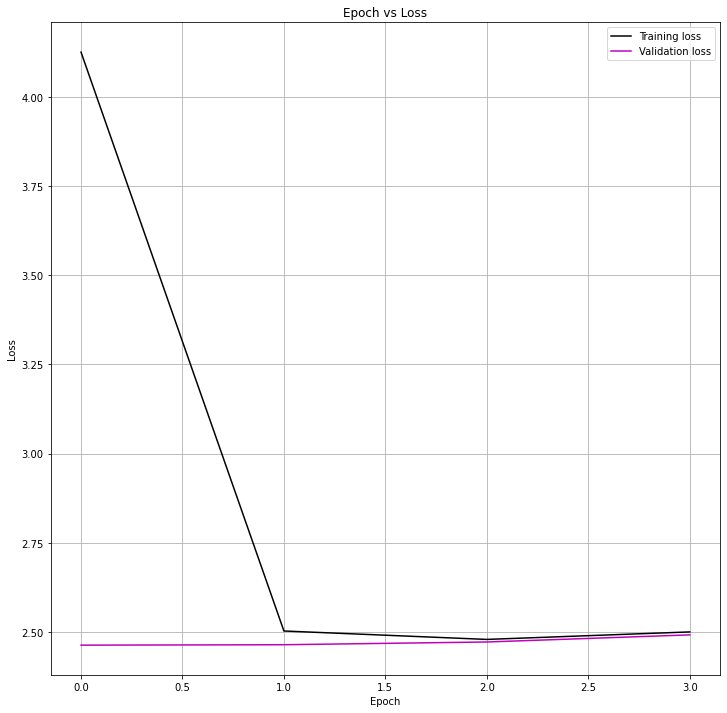

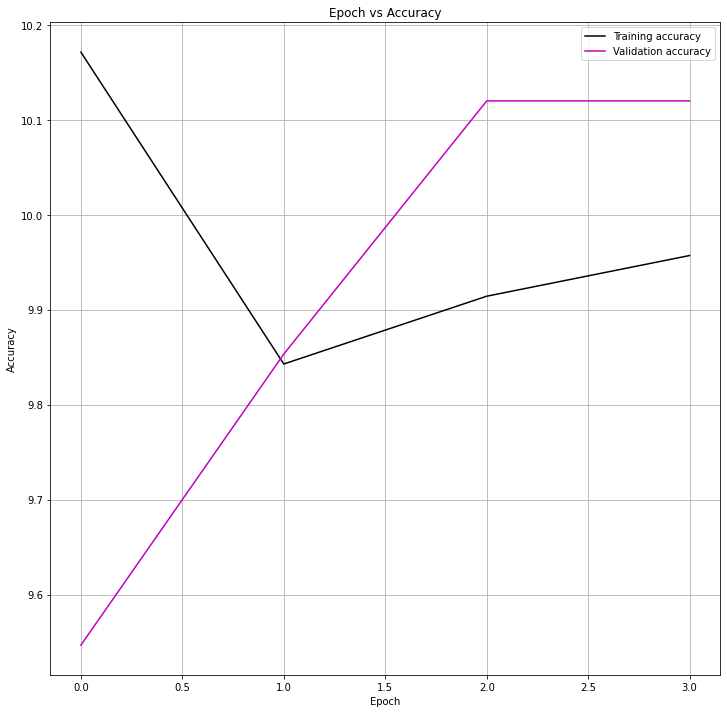



##### Evaluation module #####
Size of test data:  1250


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 107.044006 sec, available: 0.000010 sec)
INFO:smac.stats.stats.Stats:##########################################################


Accuracy:  10.0
Confusion matrix: 
 Predicted      1    All
Actual                 
0           1000   1000
1           1000   1000
2           1000   1000
3           1000   1000
4           1000   1000
5           1000   1000
6           1000   1000
7           1000   1000
8           1000   1000
9           1000   1000
All        10000  10000




INFO:smac.stats.stats.Stats:Statistics:
INFO:smac.stats.stats.Stats:#Incumbent changed: 1
INFO:smac.stats.stats.Stats:#Submitted target algorithm runs: 5 / 5.0
INFO:smac.stats.stats.Stats:#Finished target algorithm runs: 5 / 5.0
INFO:smac.stats.stats.Stats:#Configurations: 5
INFO:smac.stats.stats.Stats:Used wallclock time: 1187.25 / inf sec 
INFO:smac.stats.stats.Stats:Used target algorithm runtime: 1186.24 / inf sec
INFO:smac.stats.stats.Stats:##########################################################
INFO:smac.facade.smac_hpo_facade.SMAC4HPO:Final Incumbent: Configuration:
  activation_function, Value: 'SIGMOID'
  learning_rate, Value: 0.001
  optimizer_class, Value: 'ADAM'

INFO:smac.facade.smac_hpo_facade.SMAC4HPO:Estimated cost of incumbent: -65.630000


##### Configuration #####
Configuration:
  activation_function, Value: 'SIGMOID'
  learning_rate, Value: 0.001
  optimizer_class, Value: 'ADAM'



##### Statistics of the run #####
Learning rate:  0.001
Batch size for training:  100
Patience for early stopping:  3
Activation function:  SIGMOID
Num epochs:  10
Optimizer class:  ADAM
Regularizer level:  L2
Weight decay:  0.0
Criterion:  PyTorch Cross-Entropy
Number of train batches:  350
Number of validation batches:  150
Number of test batches:  1250
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Model summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [16, 16, 28, 28]           1,216
              ReLU-2           [16, 16, 28, 28]               0
         MaxPool2d-3           [16, 16, 14, 14]               0
            Conv2d-4           [16, 32, 10, 10]          12,832
              ReLU-5

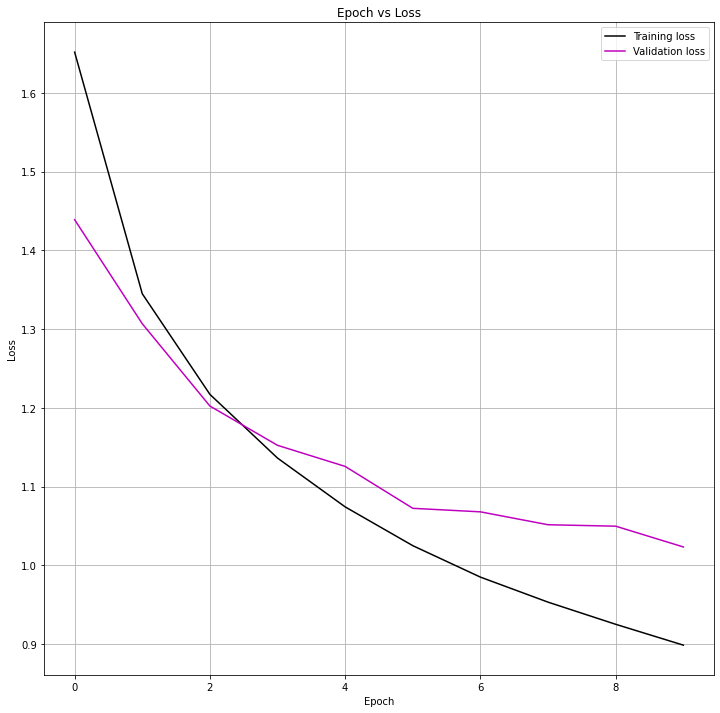

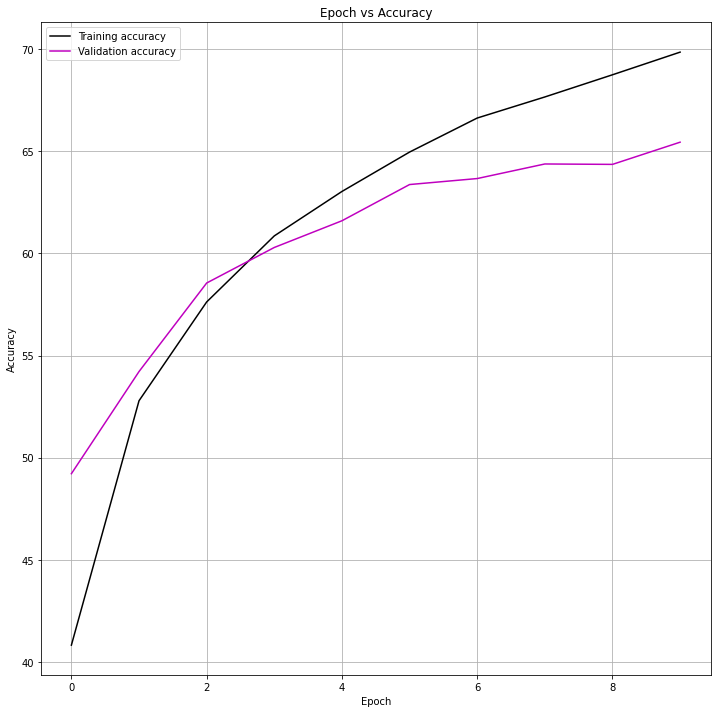



##### Evaluation module #####
Size of test data:  1250
Accuracy:  65.88000000000001
Confusion matrix: 
 Predicted    0    1     2    3     4     5     6    7    8     9    All
Actual                                                                 
0          678   33    74   22    30    13    15    9   68    58   1000
1           22  720    13    6    15    13    13    5   24   169   1000
2           51   13   542   37   126    84    88   31   12    16   1000
3           19    8   110  346    94   245   114   26   14    24   1000
4           21    6    76   30   688    37    72   48   17     5   1000
5           11    3    79  107    77   614    43   46    6    14   1000
6            8    2    41   45    55    26   796    9    7    11   1000
7           10    6    48   21   124    98    13  647    3    30   1000
8           73   50    22   16    19    10     9    2  748    51   1000
9           18   71    10    6    15    12    20   13   26   809   1000
All        911  912  1015  636

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


In [ ]:
def SMAC_based_HPO(configuration_space: ConfigurationSpace,
                  target_algorithm_wrapper: typing.Callable) -> typing.Tuple:
    
    """
    SMAC performing Bayersion Optimization with surrogate function as Random Forest
    
    Parameters:
    -----------
    configuration_space: ConfigurationSpace
        Configuration space with all hyperparameters of the classifier selected for HPO
    target_algorithm_wrapper: typing.Callable
        Target algorithm wrapper evaluated by the SMAC as an objective function.
        In our case, the objective function is NN performing classification on CIFAR10 dataset
        
    Return:
    -------
        incumbent: Configuration
            Best configuration found by SMAC performing Bayesian optimization
        -inc_value: float
            -ve of inc_value is the accuracy value. 
            This -ve is to negate the -ve assigned to perform minimization
    
    """

    # Scenario object
    scenario = Scenario({"run_obj": "quality",  # we optimize quality (alternatively runtime)
                         "runcount-limit": 5,  # max. number of function evaluations; for this example set to a low number
                         "cs": configuration_space,  # configuration space
                         "deterministic": True,
                         "limit-resources": False,
                        })

    smac = SMAC4HPO(scenario=scenario,
                    rng=np.random.RandomState(42),
                    tae_runner=target_algorithm_wrapper, 
                    initial_design=DefaultConfiguration,
                   )

    # Start optimization
    try:
        incumbent = smac.optimize()
    finally:
        incumbent = smac.solver.incumbent
        
    inc_value = smac.get_tae_runner().run(incumbent, 1)[1]
    
    return incumbent, -inc_value

configuration_space = define_search_space()
best_configuration, accuracy = SMAC_based_HPO(configuration_space, run_model_from_cfg)
print('\n###########################')
print("Best configuration found by SMAC based HPO:\n", best_configuration)
print("Accuracy of the best configuration: %.2f" % accuracy)
print('###########################\n')



##### Statistics of the run #####
Learning rate:  0.001
Batch size for training:  100
Patience for early stopping:  3
Activation function:  SIGMOID
Num epochs:  10
Optimizer class:  ADAM
Regularizer level:  L2
Weight decay:  0.0
Criterion:  PyTorch Cross-Entropy
Number of train batches:  350
Number of validation batches:  150
Number of test batches:  1250
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Model summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [16, 16, 28, 28]           1,216
              ReLU-2           [16, 16, 28, 28]               0
         MaxPool2d-3           [16, 16, 14, 14]               0
            Conv2d-4           [16, 32, 10, 10]          12,832
              ReLU-5           [16, 32, 10, 10]               0
         MaxPool2d-6             [16, 32, 5, 5]               0
            Linear-7                 

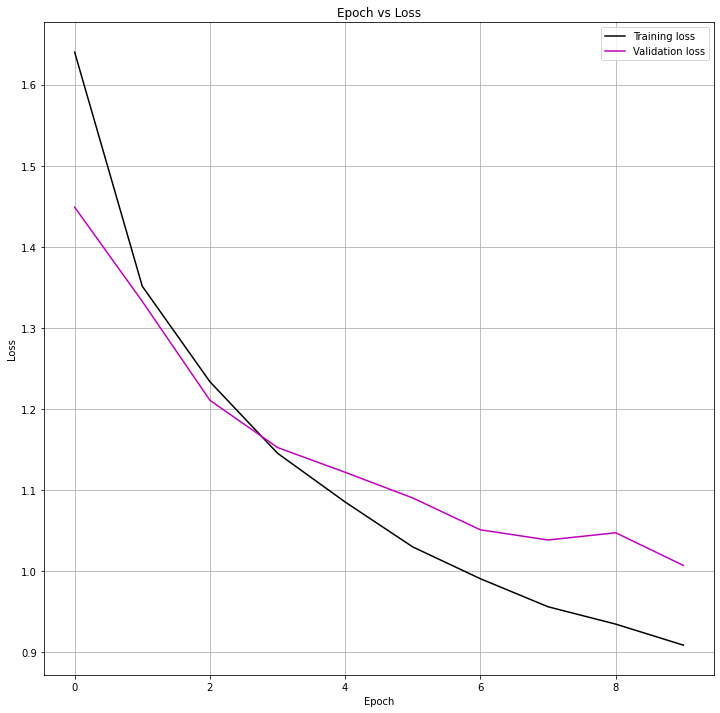

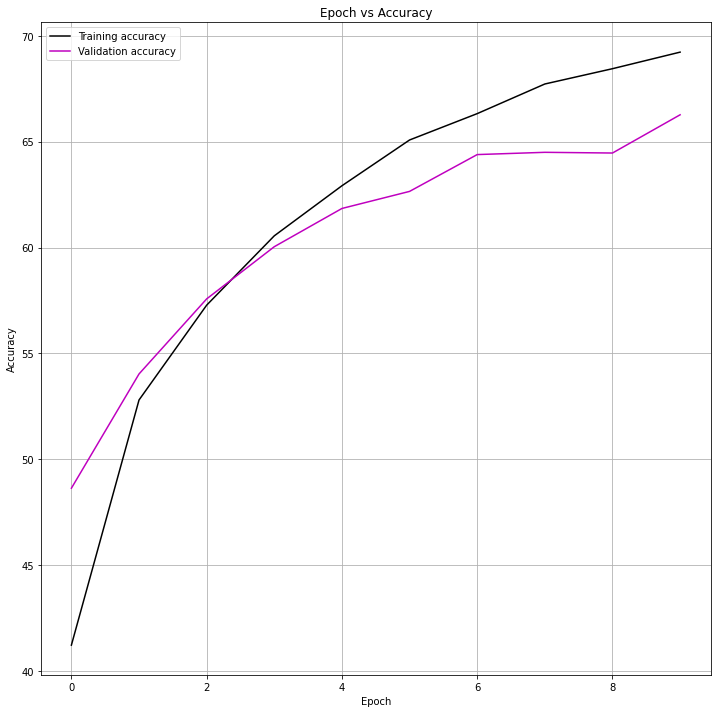



##### Evaluation module #####
Size of test data:  1250
Accuracy:  65.39
Confusion matrix: 
 Predicted    0     1     2     3    4    5    6     7     8    9    All
Actual                                                                 
0          698    27    59    25   25    5    9    20    84   48   1000
1           28   763    11    16    5    7    9     9    49  103   1000
2           62     7   574    87   93   52   56    42    18    9   1000
3           23    11    79   528   69  140   69    38    25   18   1000
4           22     4   107    80  565   41   68    85    23    5   1000
5           17     6    88   251   57  467   24    67     9   14   1000
6            5     5    60    99   55   12  736    16     9    3   1000
7           12     4    40    65   73   52   11   717     8   18   1000
8           71    41    14    20    8    8    7     6   789   36   1000
9           41   134     9    29    8    7    7    23    40  702   1000
All        979  1002  1041  1200  958  791

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


In [ ]:
# Running model with the best configuration from SMAC
cfg = best_configuration 
cfg = {k: cfg[k] for k in cfg if cfg[k]}
cfg["patience"] = PATIENCE
cfg["num_epochs"] = NUM_EPOCHS
cfg["train_batch_size"] = TRAIN_BATCH_SIZE
best_model, accuracy, writer = CIFAR10_classifier(**cfg)

In [ ]:
torch.save(best_model, "model.th")

In [ ]:
best_model = torch.load("model.th")
best_model.eval()

CNNModel(
  (cnn1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (activation1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (activation2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=800, out_features=10, bias=True)
)

# Visualizing activations for the best model trained

In [ ]:
# def visualize_activation(model,dl,output_folder):
activation = {}
def get_activation_maps(name, model):
    """
    Parameters:
    -----------
    name: str
        Name of the layer
    model: torch.nn
        PyTorch CNN model
    
    Return:
    -------
    hook: typing.Callable
        Operation to be performed at each layer of the model to manipulate the gradients after the backward pass
    
    """
    
    def hook(model, grad_input, grad_output):
        activation[name] = grad_output.detach()
    return hook

In [ ]:
def get_all_conv_layers(model):  
    """
    Parameters:
    -----------
    model: torch.nn
        PyTorch CNN model
    
    Return:
    -------
    name_of_layers: typing.List
        Name of the CNN layers
    """
        
    name_of_layers = []
    for name, module in model.named_modules():  
        if isinstance(module, nn.Sequential):
            get_all_conv_layers(module)
        if isinstance(module, nn.Conv2d):
            name_of_layers.append(name)
    return name_of_layers

conv_layers = get_all_conv_layers(best_model)
print("The convolutional layer names in the model are: ", conv_layers)

def register_forward_hook(model, layers_to_register):
    """
    Parameters:
    -----------
    model: torch.nn
        PyTorch CNN model
    layers_to_register: typing.List
        List of CNN layers to be registered with a hook function
    """
        
    for name, module in model.named_modules():
        if name in layers_to_register:
            module.register_forward_hook(get_activation_maps(name, model))
register_forward_hook(best_model, conv_layers)

The convolutional layer names in the model are:  ['cnn1', 'cnn2']


Layer:  cnn1
Output volume:  torch.Size([16, 28, 28])
Activation spatial dimension:  torch.Size([28, 28])


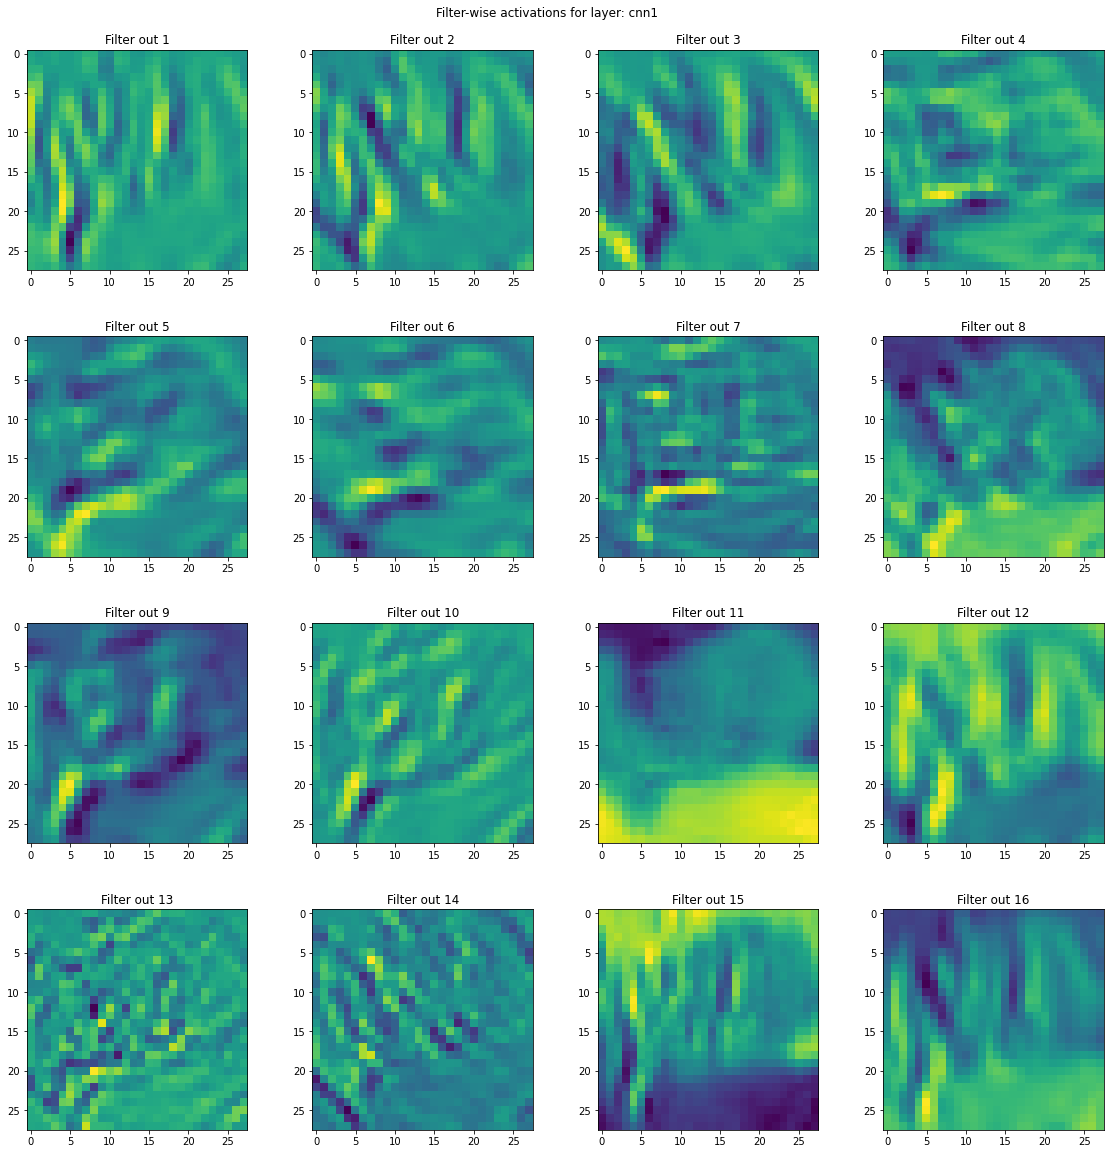

Layer:  cnn2
Output volume:  torch.Size([32, 10, 10])
Activation spatial dimension:  torch.Size([10, 10])


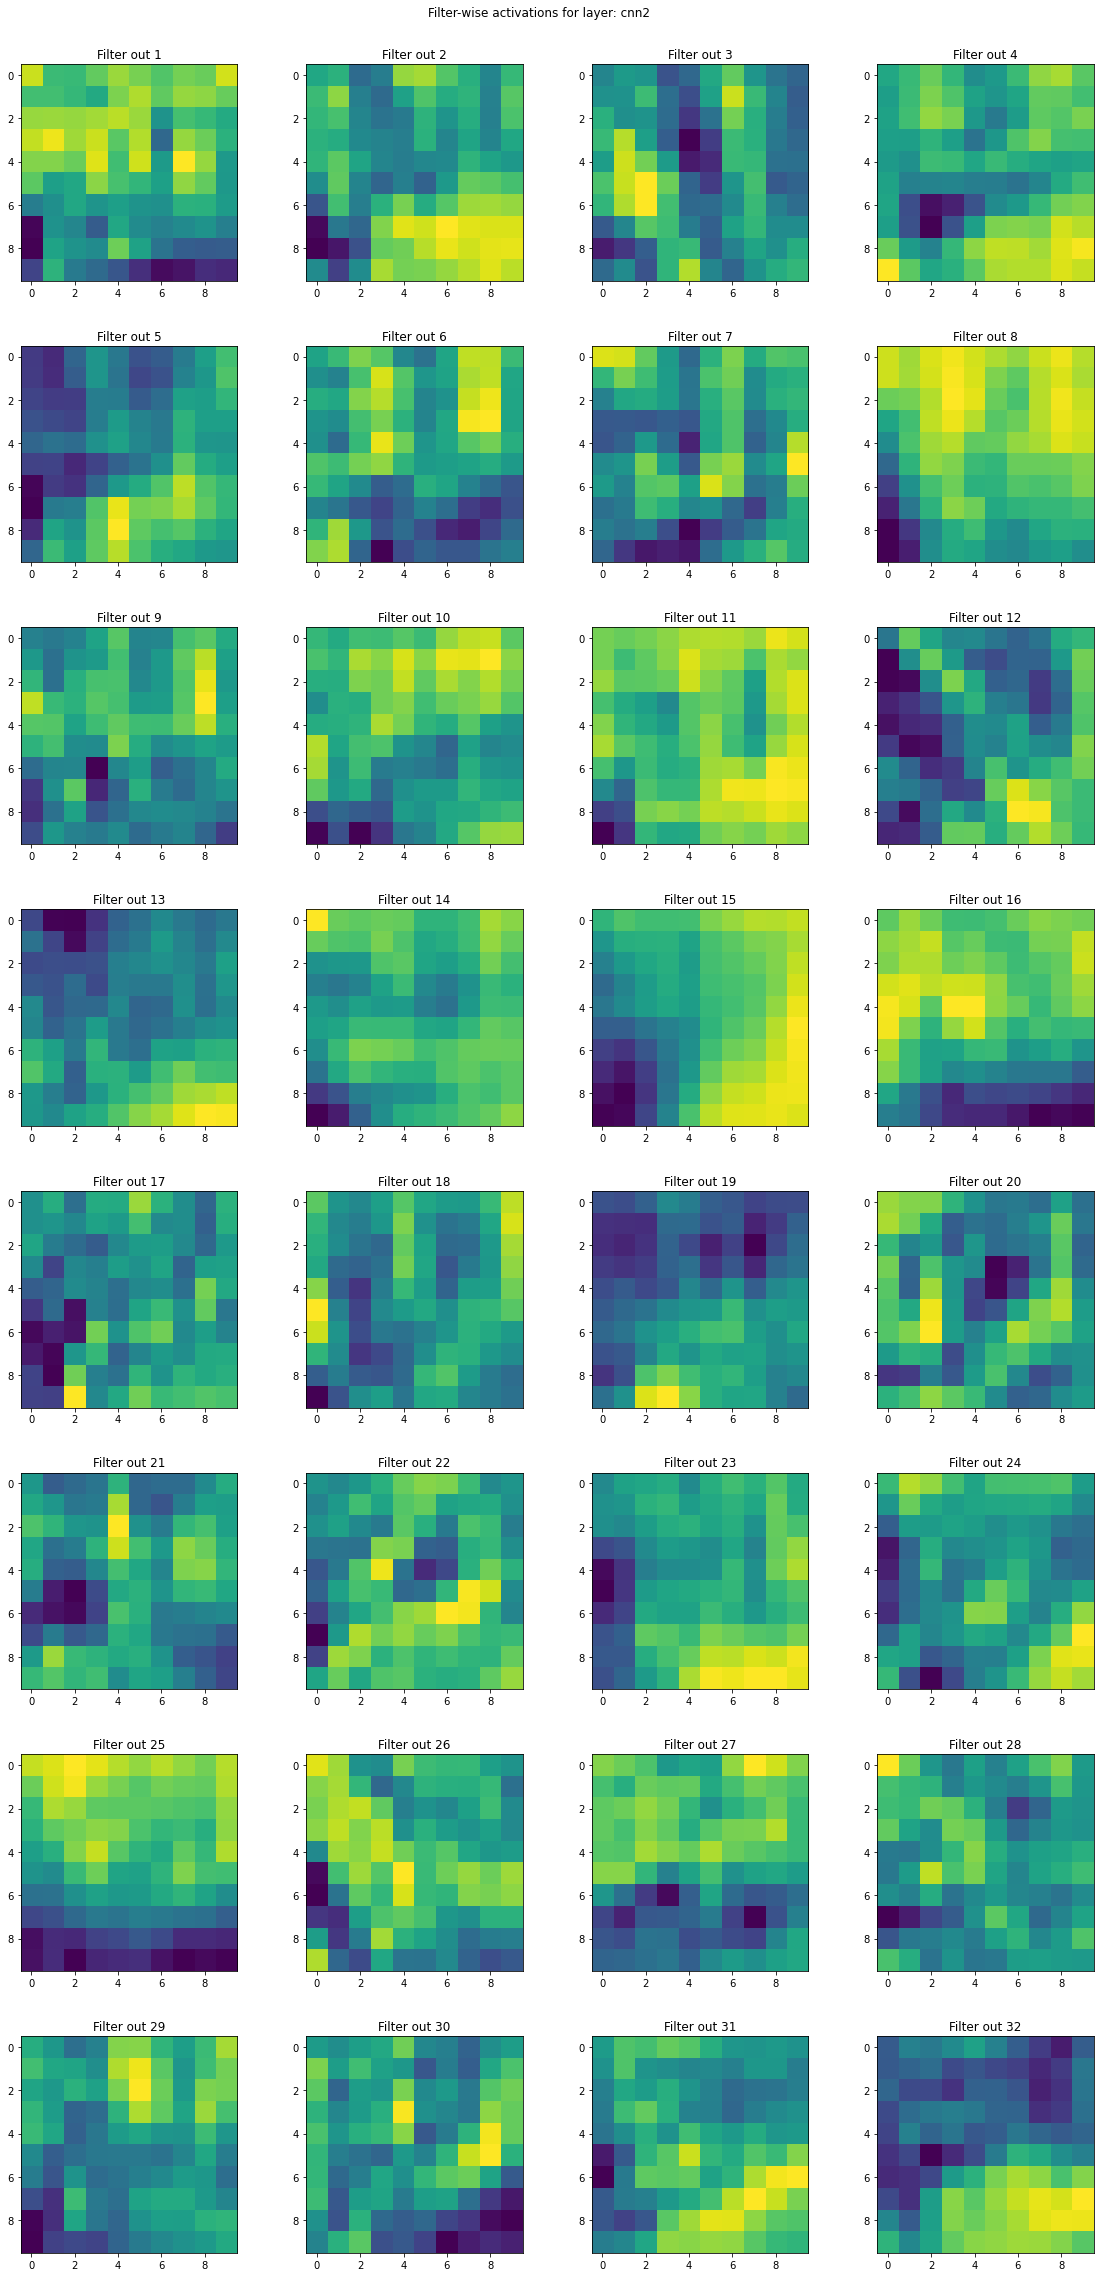

In [ ]:
def plot_activations():

    """
    Plot activations for an image
    """  
    img, label = testset[0]
    selected_filter_to_visualize = 5
    out = best_model(img.unsqueeze(0))

    for i in conv_layers:
        act = activation[i]
        act = act.squeeze(0)
        print("Layer: ", i)
        print("Output volume: ", act.shape)
        print("Activation spatial dimension: ", act[0].shape)

        plots_per_row = 4
        imgs_to_plot = act.size(0)
        rows = int(imgs_to_plot / plots_per_row) 
        columns = min(imgs_to_plot, plots_per_row)
        remaining = (imgs_to_plot - (rows * columns))
        if remaining:
            rows = rows + 1
        if rows > 5:
            fig, axs = plt.subplots(rows, columns, figsize=(20, 40), facecolor='w', edgecolor='k')
            fig.subplots_adjust(left=0.125, bottom=0.2, right=0.9, top=0.96, wspace=0.1, hspace=0.3)
        else:
            fig, axs = plt.subplots(rows, columns, figsize=(20, 20), facecolor='w', edgecolor='k')
            fig.subplots_adjust(left=0.125, bottom=0.2, right=0.9, top=0.95, wspace=0.1, hspace=0.3)

        fig.suptitle("Filter-wise activations for layer: " + i)

        axs = axs.flatten()
        for selected_filter, ax in enumerate(axs):
            ax.imshow(act[selected_filter])
            ax.set_title('Filter out ' + str(selected_filter + 1))
        plt.show()
if PLOT_ACTIVATIONS:
    plot_activations()

Size of the weight tensor in cnn1 layer is torch.Size([16, 3, 5, 5])
Number of filters in cnn1 layer is 48


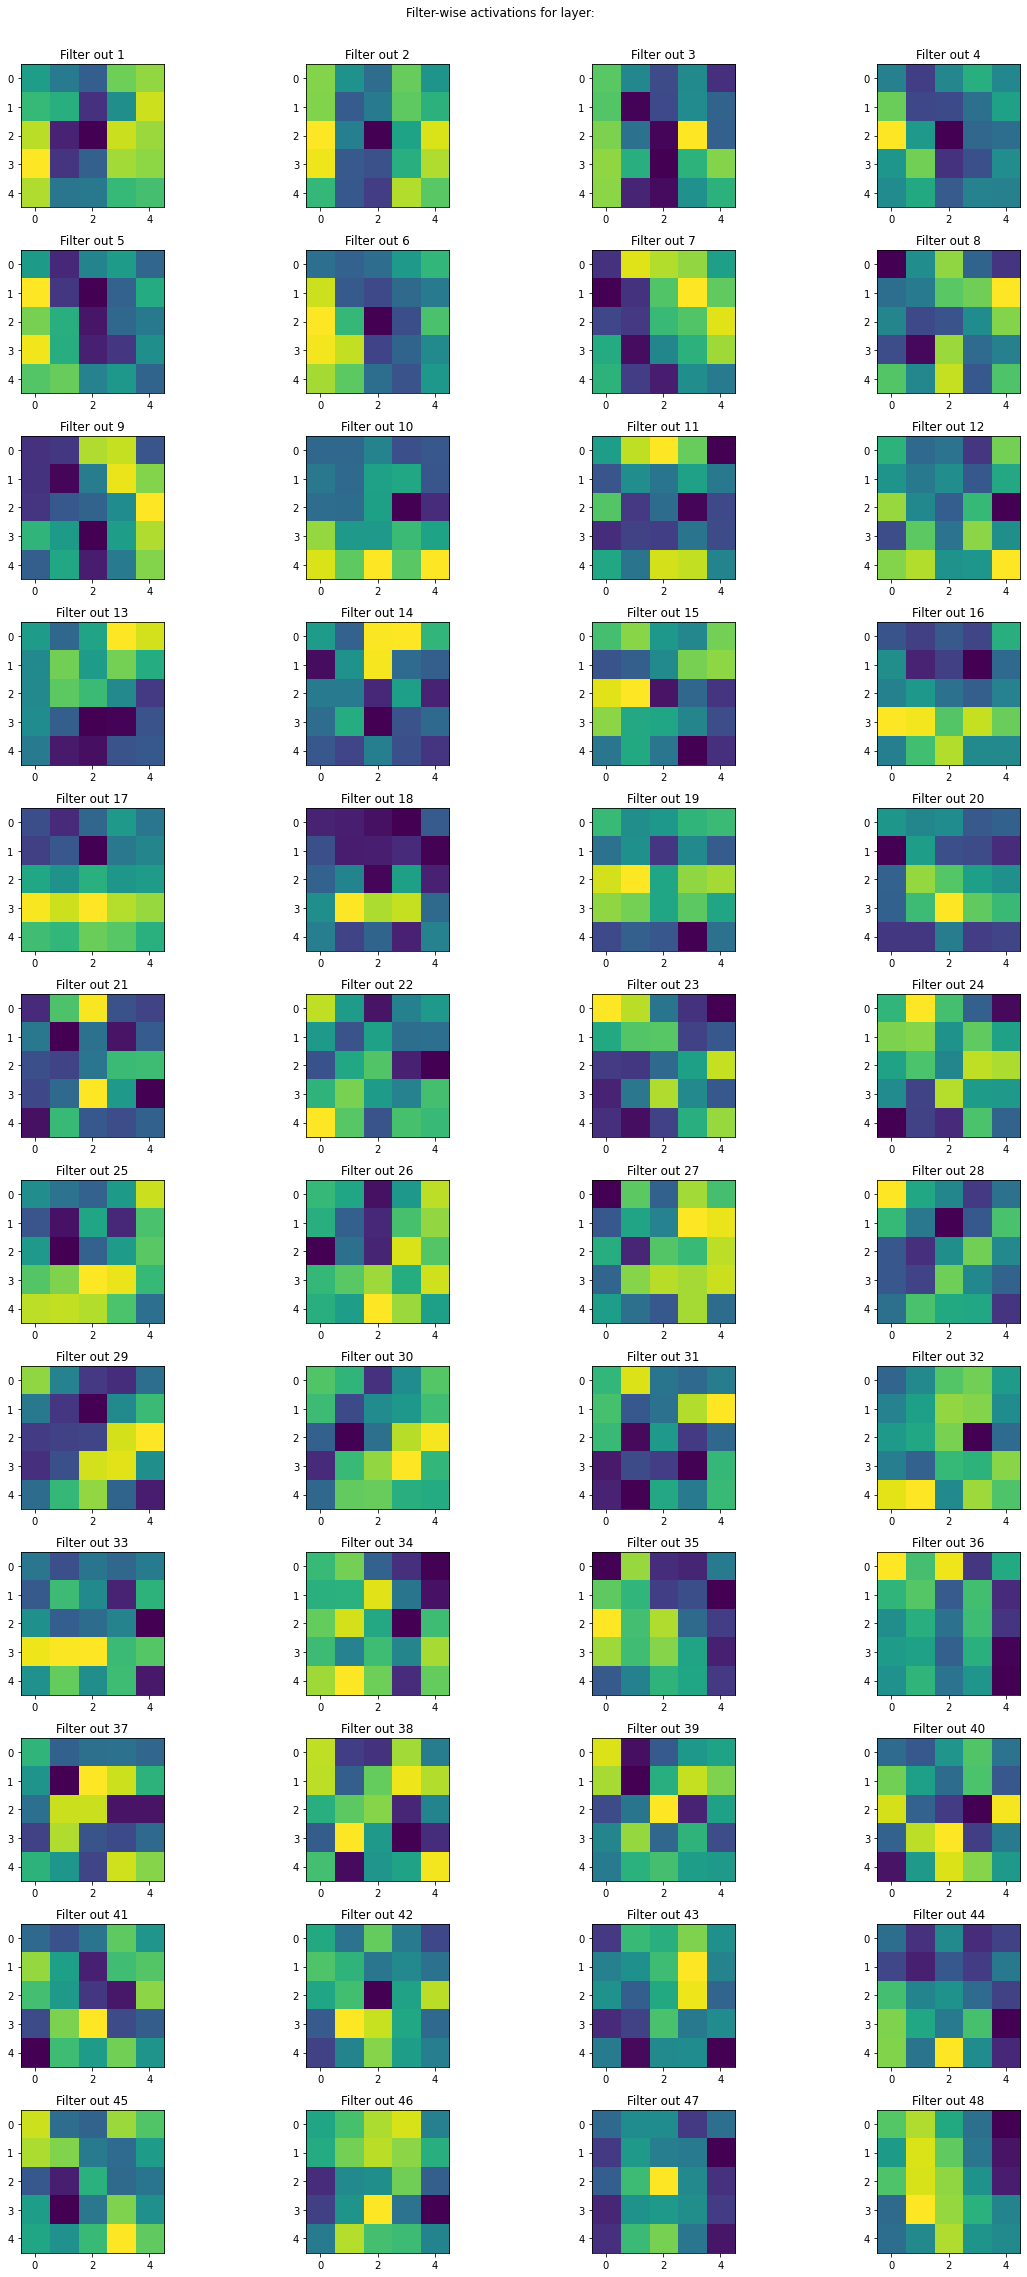

Size of the weight tensor in cnn2 layer is torch.Size([32, 16, 5, 5])
Number of filters in cnn2 layer is 512
Not plotting this layer filter just to avoid over usage of memory in the notebook.
If you want to visualize please change the argument PLOT_NUM_KERNELS_LIMIT in the function definition.


In [ ]:
def get_tensor_kernels() -> typing.List:
  """
  Get kernel tensors
  """
  tensor_kernels = []
  for name, tensor in best_model.named_parameters():
      if "weight" in name:
          if name.split(".weight")[0] in conv_layers:
              tensor_kernels.append(tensor)
  return tensor_kernels
weight_tensor_kernels = get_tensor_kernels()

def plot_weights(weight_tensor_kernels: typing.List,
                 PLOT_NUM_KERNELS_LIMIT: int = 50):
  """
  Plots kernel weights
  Parameters:
  -----------
  weight_tensor_kernels: typing.List
    CNN kernel weight values
  """
  for name, kernel_weights in zip(conv_layers, weight_tensor_kernels):
      print("Size of the weight tensor in {} layer is {}".format(name, kernel_weights.shape))
      kernel_weights = kernel_weights.reshape(kernel_weights.shape[0] * kernel_weights.shape[1], kernel_weights.shape[2], kernel_weights.shape[3])
      print("Number of filters in {} layer is {}".format(name, kernel_weights.shape[0]))
      plots_per_row = 4
      imgs_to_plot = kernel_weights.shape[0]
      if imgs_to_plot < PLOT_NUM_KERNELS_LIMIT: # The second CNN has 1024 filters. Plotting those are intensive
          rows = int(imgs_to_plot / plots_per_row) 
          columns = min(imgs_to_plot, plots_per_row)
          remaining = (imgs_to_plot - (rows * columns))
          if remaining:
              rows = rows + 1
          if rows > 5:
              fig, axs = plt.subplots(rows, columns, figsize=(20, 40), facecolor='w', edgecolor='k')
              fig.subplots_adjust(left=0.125, bottom=0.2, right=0.9, top=0.96, wspace=0.1, hspace=0.3)
          else:
              fig, axs = plt.subplots(rows, columns, figsize=(20, 20), facecolor='w', edgecolor='k')
              fig.subplots_adjust(left=0.125, bottom=0.2, right=0.9, top=0.95, wspace=0.1, hspace=0.3)
          fig.suptitle("Filter-wise activations for layer: ")
          axs = axs.flatten()
          for selected_filter, ax in enumerate(axs):
              ax.imshow(kernel_weights[selected_filter].detach().numpy())
              ax.set_title('Filter out ' + str(selected_filter + 1))
          plt.show()
      else:
          print("Not plotting this layer filter just to avoid over usage of memory in the notebook.")
          print("If you want to visualize please change the argument PLOT_NUM_KERNELS_LIMIT in the function definition.")

if PLOT_WEIGHTS:
    plot_weights(weight_tensor_kernels)




##### Statistics of the run #####
Learning rate:  0.01
Batch size for training:  100
Patience for early stopping:  3
Activation function:  RELU
Num epochs:  10
Optimizer class:  SGD
Regularizer level:  L2
Weight decay:  0
Criterion:  PyTorch Cross-Entropy
Number of train batches:  350
Number of validation batches:  150
Number of test batches:  1250
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Model summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [16, 16, 28, 28]           1,216
              ReLU-2           [16, 16, 28, 28]               0
         MaxPool2d-3           [16, 16, 14, 14]               0
            Conv2d-4           [16, 32, 10, 10]          12,832
              ReLU-5           [16, 32, 10, 10]               0
         MaxPool2d-6             [16, 32, 5, 5]               0
            Linear-7                   [16, 

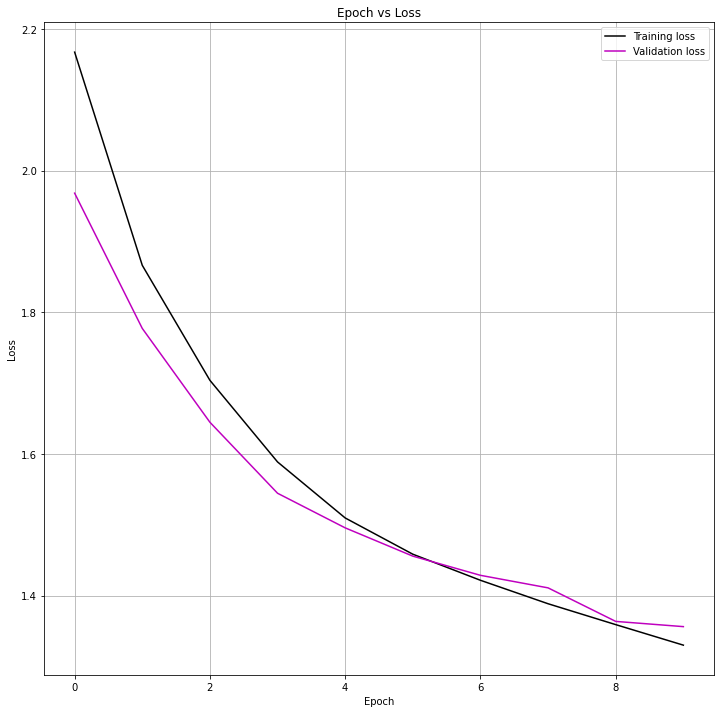

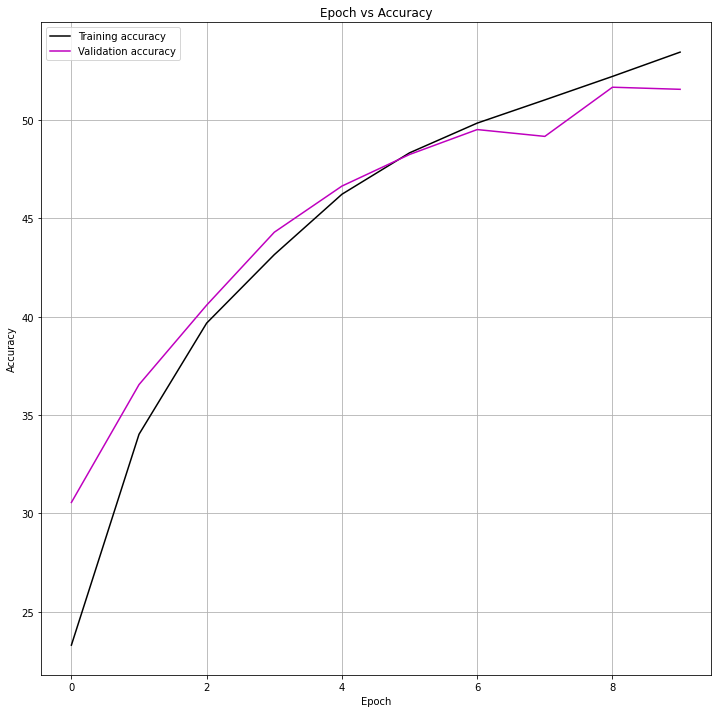



##### Evaluation module #####
Size of test data:  1250
Accuracy:  52.18000000000001
Confusion matrix: 
 Predicted     0    1     2    3    4    5     6    7    8    9    All
Actual                                                               
0           654   33   109   23    9    8    20    9  106   29   1000
1            87  613    24   15    4    7    15    5   82  148   1000
2            92   11   569   72   44   67    79   20   28   18   1000
3            41   12   176  387   44  159   107   29   15   30   1000
4            54   11   323   68  244   54   146   72   19    9   1000
5            29    2   200  200   29  413    52   47   16   12   1000
6            14    7   142   86   26   21   662   17   10   15   1000
7            41    1   117   78   46  104    34  515   10   54   1000
8           218   48    38   22    3   10    12    5  600   44   1000
9            83  141    41   22    2   14    28   23   85  561   1000
All        1313  879  1739  973  451  857  1155  742  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


In [ ]:
model, accuracy, writer = CIFAR10_classifier(experiment_name="MAX_Pool",
                                             learning_rate=LEARNING_RATE, 
                                             train_batch_size=TRAIN_BATCH_SIZE, 
                                             patience=PATIENCE, 
                                             activation_function=ACTIVATION_FUNCTION, 
                                             pooling_type="MAX",
                                             num_epochs=NUM_EPOCHS, 
                                             optimizer_class=OPTIMIZER_CLASS, 
                                             weight_decay=WEIGHT_DECAY,
                                             regularization_level=REGULARIZATION_LEVEL,
                                             criterion_class=CRITERION_CLASS,
                                             early_stopping=True,
                                             close_writer=True,
                                             additional_scalar_identifier="_MAX_Pool"
                                            )



##### Statistics of the run #####
Learning rate:  0.01
Batch size for training:  100
Patience for early stopping:  3
Activation function:  RELU
Num epochs:  10
Optimizer class:  SGD
Regularizer level:  L2
Weight decay:  0
Criterion:  PyTorch Cross-Entropy
Number of train batches:  350
Number of validation batches:  150
Number of test batches:  1250
AvgPool2d(kernel_size=2, stride=2, padding=0)
Model summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [16, 16, 28, 28]           1,216
              ReLU-2           [16, 16, 28, 28]               0
         AvgPool2d-3           [16, 16, 14, 14]               0
            Conv2d-4           [16, 32, 10, 10]          12,832
              ReLU-5           [16, 32, 10, 10]               0
         AvgPool2d-6             [16, 32, 5, 5]               0
            Linear-7                   [16, 10]           8,010
Total par

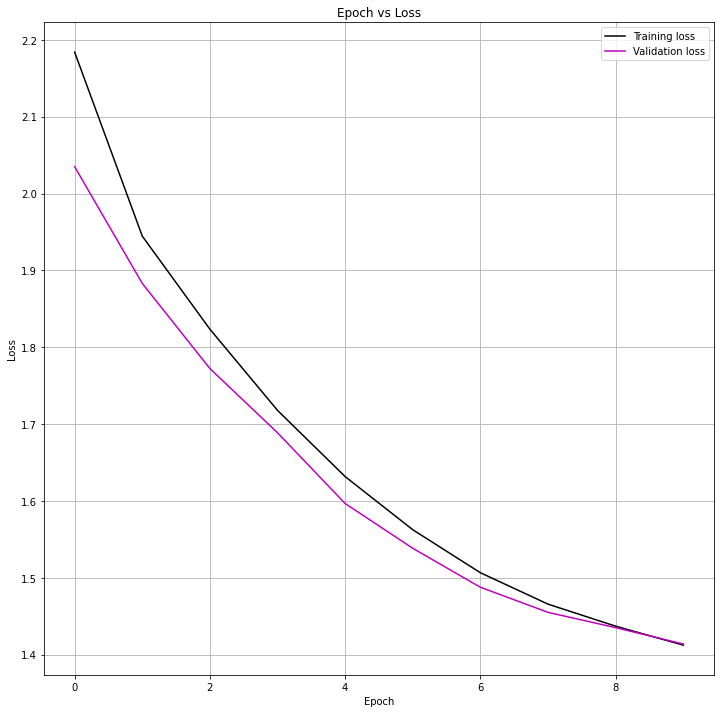

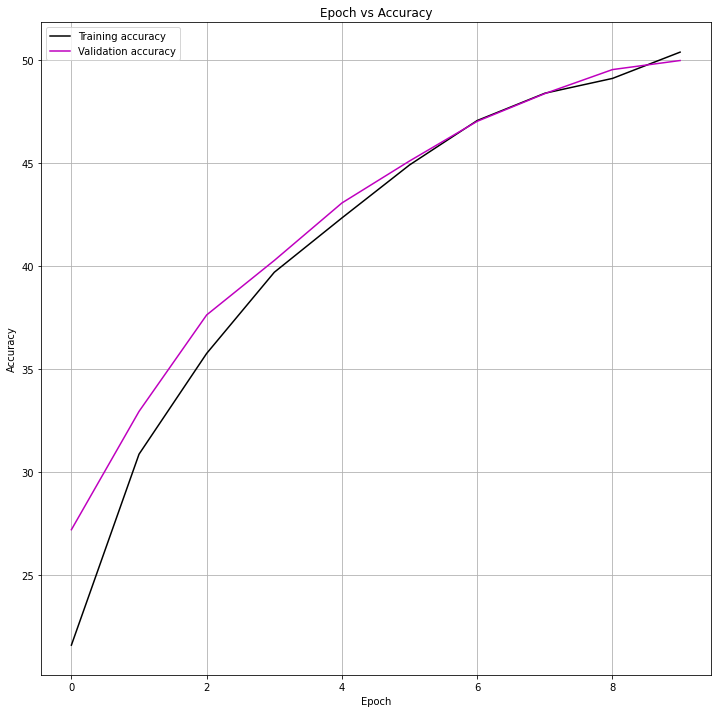



##### Evaluation module #####
Size of test data:  1250
Accuracy:  50.55
Confusion matrix: 
 Predicted     0     1    2    3    4     5     6     7     8    9    All
Actual                                                                  
0           570    64   70   15   23    18    20    33   141   46   1000
1            49   702    7    9    6    10    12    20    70  115   1000
2            73    29  345   55  119   110   126    92    29   22   1000
3            37    27   78  182   51   274   174   118    13   46   1000
4            51    24  137   31  338    72   162   142    29   14   1000
5            16    10   86   84   46   496    84   140    20   18   1000
6            10    19   64   42   81    49   648    46    10   31   1000
7            32    22   31   32   40   106    43   639     6   49   1000
8           153    94   13   12   13    13    13    19   620   50   1000
9            48   210   14   10    8    29    30    50    86  515   1000
All        1039  1201  845  47

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


In [ ]:
model, accuracy, writer = CIFAR10_classifier(experiment_name="AVERAGE_Pool",
                                             learning_rate=LEARNING_RATE, 
                                             train_batch_size=TRAIN_BATCH_SIZE, 
                                             patience=PATIENCE, 
                                             activation_function=ACTIVATION_FUNCTION, 
                                             pooling_type="AVERAGE",
                                             num_epochs=NUM_EPOCHS, 
                                             optimizer_class=OPTIMIZER_CLASS, 
                                             weight_decay=WEIGHT_DECAY,
                                             regularization_level=REGULARIZATION_LEVEL,
                                             criterion_class=CRITERION_CLASS,
                                             early_stopping=True,
                                             close_writer=True,
                                             additional_scalar_identifier="_AVERAGE_Pool"
                                            )



##### Statistics of the run #####
Learning rate:  0.01
Batch size for training:  100
Patience for early stopping:  3
Activation function:  RELU
Num epochs:  10
Optimizer class:  SGD
Regularizer level:  L2
Weight decay:  0
Criterion:  PyTorch Cross-Entropy
Number of train batches:  350
Number of validation batches:  150
Number of test batches:  1250
Hybrid(
  (cnn): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1))
)
Model summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [16, 16, 28, 28]           1,216
              ReLU-2           [16, 16, 28, 28]               0
            Conv2d-3           [16, 16, 14, 14]             528
            Hybrid-4           [16, 16, 14, 14]               0
            Conv2d-5           [16, 32, 10, 10]          12,832
              ReLU-6           [16, 32, 10, 10]               0
            Conv2d-7             [16, 32, 5, 5]   

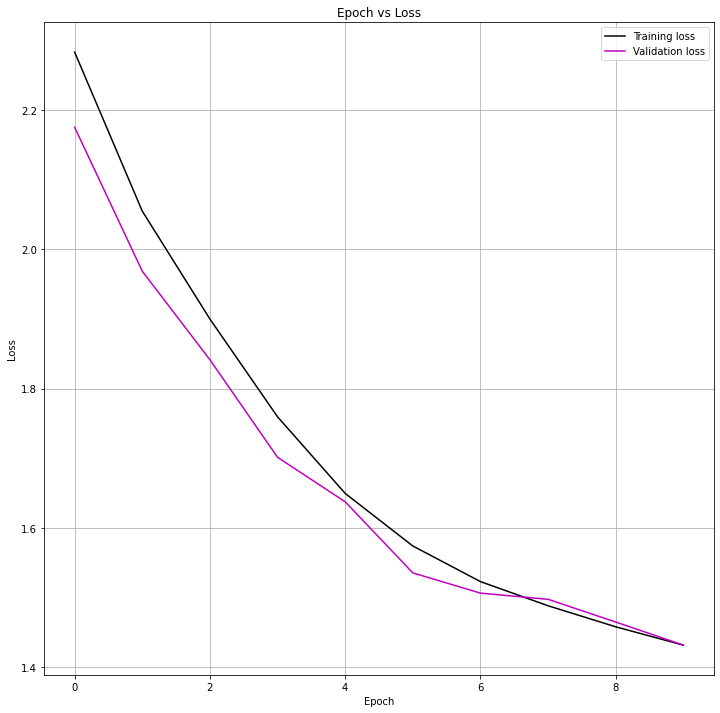

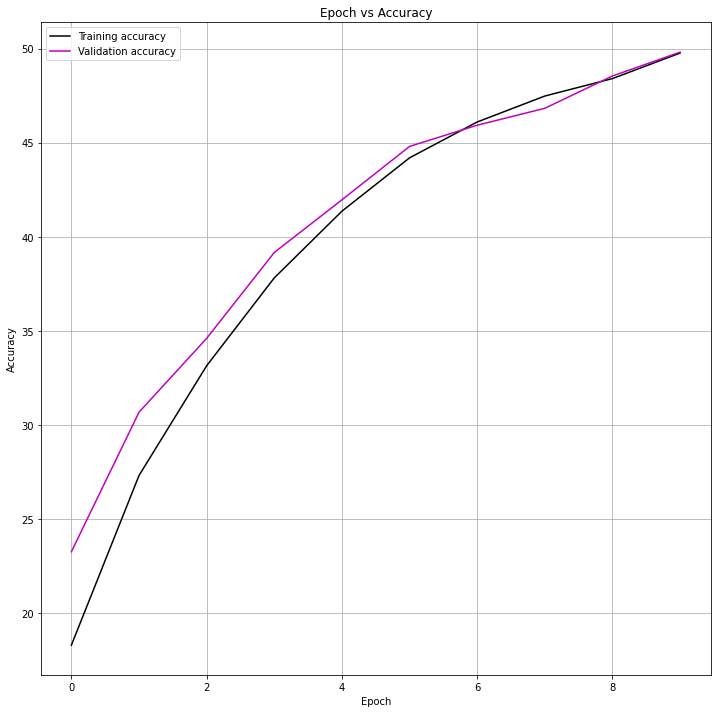



##### Evaluation module #####
Size of test data:  1250
Accuracy:  49.57
Confusion matrix: 
 Predicted    0     1    2    3    4    5     6     7     8     9    All
Actual                                                                 
0          503    76   73   25   30    8    18    24   174    69   1000
1           31   715   10    5    8    2    19    11    62   137   1000
2           83    29  362   72  133   65    96    91    39    30   1000
3           34    37   76  271  102  170   131   106    16    57   1000
4           47    26  161   52  380   39   135   125    22    13   1000
5           18    14   92  145   68  377    74   173    14    25   1000
6            7    28   67   65   94   24   607    54    10    44   1000
7           26    17   26   61   81   69    37   605    15    63   1000
8          148   103   21   18    6    6     8    14   604    72   1000
9           47   224   18   18    8    9    39    37    67   533   1000
All        944  1269  906  732  910  769  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


In [ ]:
model, accuracy, writer = CIFAR10_classifier(experiment_name="HYBRID_Pool",
                                             learning_rate=LEARNING_RATE, 
                                             train_batch_size=TRAIN_BATCH_SIZE, 
                                             patience=PATIENCE, 
                                             activation_function=ACTIVATION_FUNCTION, 
                                             pooling_type="HYBRID",
                                             num_epochs=NUM_EPOCHS, 
                                             optimizer_class=OPTIMIZER_CLASS, 
                                             weight_decay=WEIGHT_DECAY,
                                             regularization_level=REGULARIZATION_LEVEL,
                                             criterion_class=CRITERION_CLASS,
                                             early_stopping=True,
                                             close_writer=True,
                                             additional_scalar_identifier="_HYBRID_Pool"
                                            )

### Findings from the experiment:
1. In CIFAR10, for the architecture chose and for 10 epochs, the max pooling layer works better compared to the model with concatenation of max and average pool and average pool layers.
2. However, contrasting behaviors were seen across the varying epoch limits. For epoch less than 5 the concatenated pooling worked better than others. 
3. A proper comparison between the pooling layers can be done by training the model with more epochs.

# Convolution layers alternatives for Fully connected layers

In [68]:
input_tensor = torch.randn((16, 3, 32, 32))
print("Shape of input tensor: ", input_tensor.shape)
cnn_layer = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=32)
fc_layer = nn.Linear(in_features=input_tensor.shape[1] * input_tensor.shape[2] * input_tensor.shape[3], out_features=10)

Shape of input tensor:  torch.Size([16, 3, 32, 32])


In [80]:
out_cnn_layer = cnn_layer(input_tensor)
print("Shape of output from CNN layer: ", out_cnn_layer.shape)

cnn_w = cnn_layer.weight.data
cnn_b = cnn_layer.bias.data
print("Shape of CNN layer weights: ", cnn_w.shape)
print("Shape of CNN layer bias: ", cnn_b.shape)

input_tensor_flatten = input_tensor.view(input_tensor.size(0), -1)
out_fc_layer = fc_layer(input_tensor_flatten)
print("Shape of output from FC layer: ", out_fc_layer.shape)

fc_w = fc_layer.weight.data
fc_b = fc_layer.bias.data
print("Shape of FC layer weights: ", fc_w.shape)
print("Shape of FC layer bias: ", fc_b.shape)

# Assign the weight of FC layer from the CNN layer
fc_w_new = cnn_w.view(fc_w.size(0), fc_w.size(-1))
fc_layer.weight.data = fc_w_new
# Assign the bias of cnn to fcn
fc_b_new = cnn_b
fc_layer.bias.data = fc_b_new

out_fc_layer_new = fc_layer(input_tensor_flatten)
print("Shape of output from FC layer new weights: ", out_fc_layer_new.shape)

Shape of output from CNN layer:  torch.Size([16, 10, 1, 1])
Shape of CNN layer weights:  torch.Size([10, 3, 32, 32])
Shape of CNN layer bias:  torch.Size([10])
Shape of output from FC layer:  torch.Size([16, 10])
Shape of FC layer weights:  torch.Size([10, 3072])
Shape of FC layer bias:  torch.Size([10])
Shape of output from FC layer new weights:  torch.Size([16, 10])




##### Statistics of the run #####
Learning rate:  0.01
Batch size for training:  100
Patience for early stopping:  3
Activation function:  RELU
Num epochs:  10
Optimizer class:  SGD
Regularizer level:  L2
Weight decay:  0
Criterion:  PyTorch Cross-Entropy
Number of train batches:  350
Number of validation batches:  150
Number of test batches:  1250
Model summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [16, 5, 30, 30]             140
              ReLU-2            [16, 5, 30, 30]               0
            Conv2d-3            [16, 5, 15, 15]              55
            Hybrid-4            [16, 5, 15, 15]               0
            Linear-5                  [16, 100]         112,600
            Linear-6                   [16, 10]           1,010
Total params: 113,805
Trainable params: 113,805
Non-trainable params: 0
-----------------------------------------------

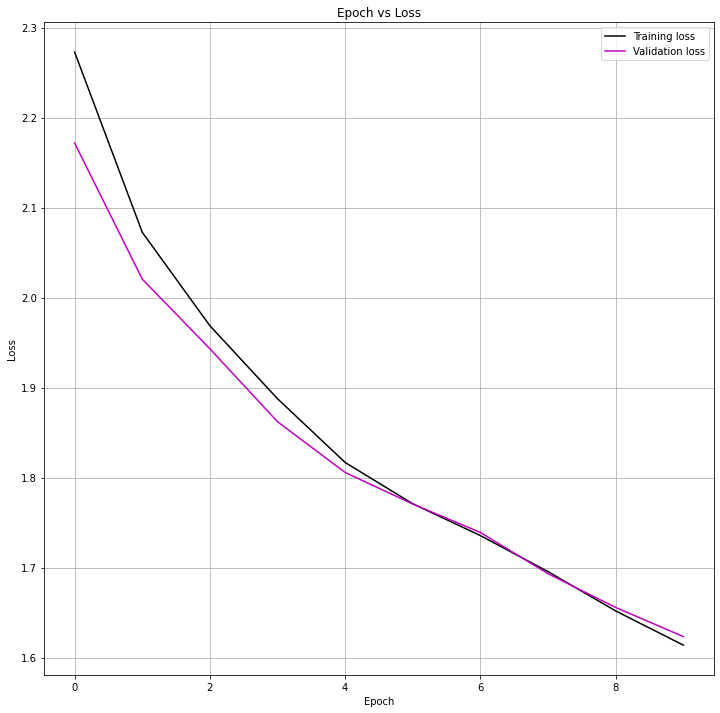

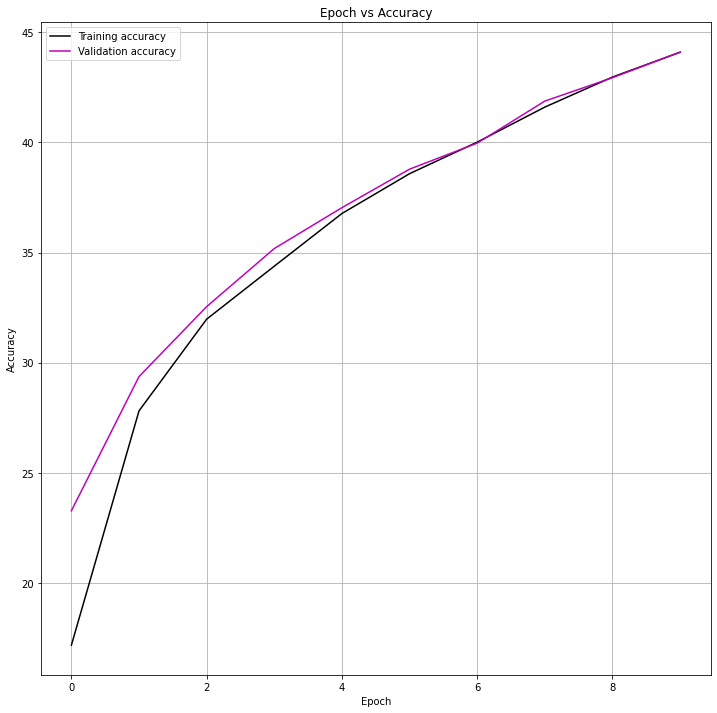



##### Evaluation module #####
Size of test data:  1250
Accuracy:  44.45
Confusion matrix: 
 Predicted     0     1    2    3    4    5     6     7     8     9    All
Actual                                                                  
0           506    40   67   31   31   21    19    35   210    40   1000
1            44   520   17   31   27   34    28    40    71   188   1000
2            92    24  351   74  168   76    98    55    47    15   1000
3            62    58  116  220   74  164   133    71    44    58   1000
4            53    24  180   56  363   59   119    99    29    18   1000
5            51    33  106  120   79  332    84   129    41    25   1000
6            12    35   69   81  125   39   537    49    20    33   1000
7            40    27   53   70   78   82    43   506    18    83   1000
8           155    53   28   27   14   31    12    16   595    69   1000
9            52   186   12   36   11   24    33    39    92   515   1000
All        1067  1000  999  74

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


In [ ]:
class Model_FCN(nn.Module):
    def __init__(self, activation_function="RELU", pooling_type="MAX"):
        super(Model_FCN, self).__init__()
        midChannels = [5]
        pooling_layer = get_pooling(pooling_type,midChannels)
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=5, kernel_size=3, stride=1, padding=0)
        self.activation = get_activation(activation_function)
        self.pool1 =  pooling_layer[0] # Output at this layer = 5, 15, 15
        self.fcn_last1 = nn.Linear(in_features=5*15*15, out_features=100) # Number of parameters = 5 * 15 * 15 * 100
        self.fcn_last2 = nn.Linear(in_features=100, out_features=10) # Number of parameters = 100 * 10
    def forward(self,x):
        out = self.cnn1(x)
        out = self.activation(out)
        out = self.pool1(out)
        out = out.view(out.size(0), -1)
        out = self.fcn_last1(out)
        out = self.fcn_last2(out)
        return out

fcn_, accuracy, writer = CIFAR10_classifier(experiment_name="FCN",
                                             learning_rate=LEARNING_RATE, 
                                             train_batch_size=TRAIN_BATCH_SIZE, 
                                             patience=PATIENCE, 
                                             activation_function=ACTIVATION_FUNCTION, 
                                             pooling_type=POOLING_TYPE,
                                             num_epochs=NUM_EPOCHS, 
                                             optimizer_class=OPTIMIZER_CLASS, 
                                             weight_decay=WEIGHT_DECAY,
                                             regularization_level=REGULARIZATION_LEVEL,
                                             criterion_class=CRITERION_CLASS,
                                             early_stopping=True,
                                             close_writer=True,
                                             additional_scalar_identifier="_FCN",
                                             model_type="FCN",
                                            )





##### Statistics of the run #####
Learning rate:  0.01
Batch size for training:  100
Patience for early stopping:  3
Activation function:  RELU
Num epochs:  10
Optimizer class:  SGD
Regularizer level:  L2
Weight decay:  0
Criterion:  PyTorch Cross-Entropy
Number of train batches:  350
Number of validation batches:  150
Number of test batches:  1250
Model summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [16, 5, 30, 30]             140
              ReLU-2            [16, 5, 30, 30]               0
            Conv2d-3            [16, 5, 15, 15]              55
            Hybrid-4            [16, 5, 15, 15]               0
            Conv2d-5            [16, 100, 1, 1]         112,600
            Conv2d-6             [16, 10, 1, 1]           1,010
Total params: 113,805
Trainable params: 113,805
Non-trainable params: 0
-----------------------------------------------

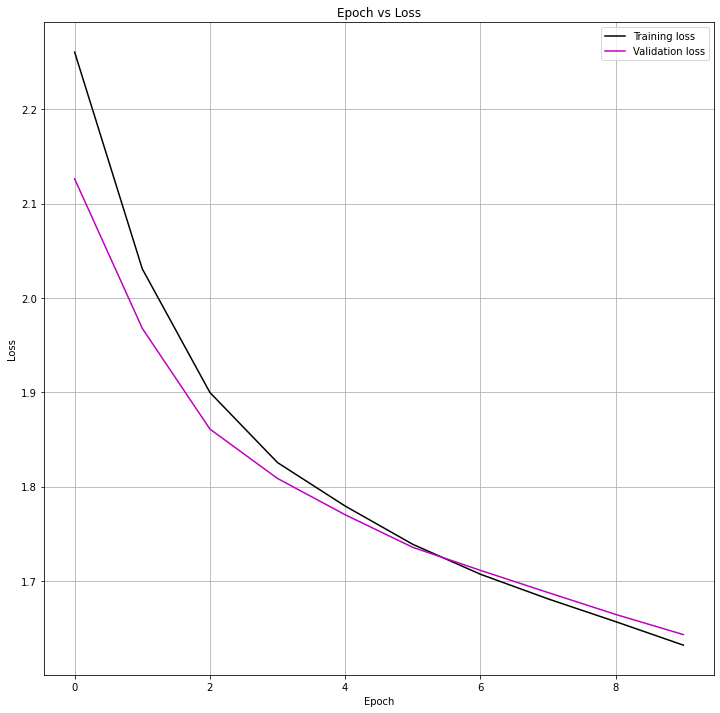

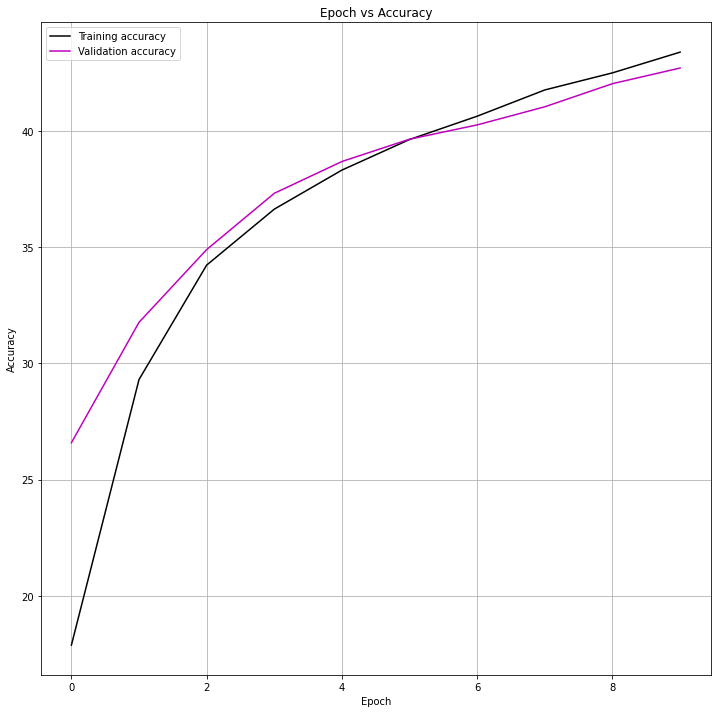



##### Evaluation module #####
Size of test data:  1250
Accuracy:  43.19
Confusion matrix: 
 Predicted    0     1    2    3    4    5     6     7     8     9    All
Actual                                                                 
0          449    67   58   30   22   16    21    51   208    78   1000
1           47   575   19   17   11   32    22    35    66   176   1000
2           70    65  195   79  182   58   175    96    56    24   1000
3           25    61   84  193   52  202   205    87    31    60   1000
4           39    25   81   42  349   72   204   134    35    19   1000
5           16    43   77  103   85  368    99   141    42    26   1000
6            7    25   41   62  103   62   625    42    10    23   1000
7           28    46   39   49   81   81    45   523    36    72   1000
8          104    80   28   14   10   43    16    25   570   110   1000
9           33   231   10   27   18   23    43    42   101   472   1000
All        818  1218  632  616  913  957  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


In [81]:
class Model_CNN(nn.Module):
    def __init__(self, activation_function="RELU", pooling_type="MAX"):
        super(Model_CNN, self).__init__()
        midChannels = [5]
        pooling_layer = get_pooling(pooling_type,midChannels)
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=5, kernel_size=3, stride=1, padding=0)
        self.activation = get_activation(activation_function)
        self.pool1 = pooling_layer[0] # 5, 15, 15
        self.cnn_last1 = nn.Conv2d(in_channels=5, out_channels=100, kernel_size=15, stride=1, padding=0) # Number of parameters = 5 * 15 * 15 * 100
        self.cnn_last2 = nn.Conv2d(in_channels=100, out_channels=10, kernel_size=1, stride=1, padding=0) # Number of parameters = 100 * 10
    def forward(self,x):
        out = self.cnn1(x)
        out = self.activation(out)
        out = self.pool1(out)
        out = self.cnn_last1(out)
        out = self.cnn_last2(out)
        out = out.view(out.size(0), -1)
        return out
    
cnn_, accuracy, writer = CIFAR10_classifier(experiment_name="Fully_CNN",
                                             learning_rate=LEARNING_RATE, 
                                             train_batch_size=TRAIN_BATCH_SIZE, 
                                             patience=PATIENCE, 
                                             activation_function=ACTIVATION_FUNCTION, 
                                             pooling_type=POOLING_TYPE,
                                             num_epochs=NUM_EPOCHS, 
                                             optimizer_class=OPTIMIZER_CLASS, 
                                             weight_decay=WEIGHT_DECAY,
                                             regularization_level=REGULARIZATION_LEVEL,
                                             criterion_class=CRITERION_CLASS,
                                             early_stopping=True,
                                             close_writer=True,
                                             additional_scalar_identifier="_Fully_CNN",
                                             model_type="Full_CNN",
                                            )




In [ ]:
# Assigning the weights of CNN to FCN

cnn_last1_w = cnn_.cnn_last1.weight.data
cnn_last1_b = cnn_.cnn_last1.bias.data
# Refering the model with last layer CNN as CNN model
# Last 1 refers to the first CNN at the end of the model which potentially replaces FCN 1
print("Shape of CNN last 1 model weights and bias: ", cnn_last1_w.shape, cnn_last1_b.shape)
cnn_last2_w = cnn_.cnn_last2.weight.data
cnn_last2_b = cnn_.cnn_last2.bias.data
# Refering the model with last layer CNN as CNN model
# Last 2 refers to the second CNN at the end of the model which potentially replaces FCN 2 by a 1 x 1 kernel
print("Shape of CNN last 2 model weights and bias: ", cnn_last2_w.shape, cnn_last2_b.shape)

fcn_last1_w = fcn_.fcn_last1.weight.data
fcn_last1_b = fcn_.fcn_last1.bias.data
# Refering the model with last layer FCN as FCN model
print("Shape of FCN last 1 model weights and bias: ", fcn_last1_w.shape, fcn_last1_b.shape)

fcn_last2_w = fcn_.fcn_last2.weight.data
fcn_last2_b = fcn_.fcn_last2.bias.data
# Refering the model with last layer FCN as FCN model
print("Shape of FCN last 2 model weights and bias: ", fcn_last2_w.shape, fcn_last2_b.shape)

# Assign the weights of cnn to fcn
fcn_last1_w = cnn_last1_w.view(fcn_last1_w.size(0), fcn_last1_w.size(-1))
fcn_last2_w = cnn_last2_w.view(fcn_last2_w.size(0), fcn_last2_w.size(-1))
# Assign the bias of cnn to fcn
fcn_last1_b = cnn_last1_b
fcn_last2_b = cnn_last2_b

img, label = testset[0]
img.unsqueeze_(0)
out_cnn = cnn_(img)
out_fcn = fcn_(img)
print("Output shape from CNN model: ", out_cnn.shape)
print("Output shape from FCN model, where FCN model last layer weights are replaced by CNN model last layers trained with convolutional layers: ", out_fcn.shape)

Shape of CNN last 1 model weights and bias:  torch.Size([100, 5, 15, 15]) torch.Size([100])
Shape of CNN last 2 model weights and bias:  torch.Size([10, 100, 1, 1]) torch.Size([10])
Shape of FCN last 1 model weights and bias:  torch.Size([100, 1125]) torch.Size([100])
Shape of FCN last 2 model weights and bias:  torch.Size([10, 100]) torch.Size([10])
Output shape from CNN model:  torch.Size([1, 10])
Output shape from FCN model, where FCN model last layer weights are replaced by CNN model last layers trained with convolutional layers:  torch.Size([1, 10])


### Findings from the experiment:
1. A Fully Connected (FC) layer looking at an input volume with spatial dimension n x n and channels m can be replaced by a convolutional layer with kernel size n x n and input channels m. In this scenario, the output features from FC layer can be, say f features and the output channels from the convolutional layer can be f channels.
2. All FC layers can be replaced by a convolutional layer with same number of parameter. However, the vice versa of replacing all convolutional layers with fully connected layer will not provide the advantages of a convolutional layer (local connectivity and parameter sharing) and drastically increases the number of parameters.
3. In a single forward pass, a fully convolutional network enables us to work with large/ variable size images to generate a larger feature map at the output which can be averaged to get class scores for the overall images. In contrast, with a FC layer, we either have to work on a fixed size random crops of the larger image or downsample to a larger stride to match the fixed size input features of the FC layer. The fully convolutuional architecture helps with efficient the forward pass computations.  "This trick is often used in practice to get better performance, where for example, it is common to resize an image to make it bigger, use a fully convolutional network to evaluate the class scores at many spatial positions and then average the class scores." [Refer this article for a detailed explanation](https://cs231n.github.io/convolutional-networks/#convert) [4].

# Self-attention to CIFAR10 classifier

The methodology implemented is similar to the paper "Learn to pay attention" available at https://openreview.net/pdf?id=HyzbhfWRW [5] and implementation available at https://github.com/SaoYan/LearnToPayAttention [6].

In the below cell, the model used is a simple 3 layer CNN followed by a fully connected CNN layer. In contrast to the original paper, only the model here is very small and simple to manage the computational bottlenecks. In the paper, the outputs are from a convolutional blocks at different depths of the model. In this assignment, it is just from a single convolutional layer just illustrating the working in the code below. Similar to the paper, the attention weights are computed using the outputs from 3 layers.

The output features for activation are very less in this assignment compared to the original paper to a factor of 11 times (original paper=512, in this assignment=48) as the computation took a large amount of time for CIFAR10 data.

In [83]:
class CNN_attention(nn.Module):
    def __init__(self, activation_function, pooling_type):
        super(CNN_attention, self).__init__()

        midChannels = [16, 32, 48]
        
        activation = torch.nn.ReLU()
        
        pooling_layer = get_pooling(pooling_type,midChannels)
        
        
        # Convolution 1
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=midChannels[0], kernel_size=3, stride=1, padding=1)
        self.activation1 = activation

        # Max pool 1
        self.pool1 = pooling_layer[0]

        # Convolution 2
        self.cnn2 = nn.Conv2d(in_channels=midChannels[0], out_channels=midChannels[1], kernel_size=3, stride=1, padding=1)
        self.activation2 = activation

        # Max pool 2
        self.pool2 = pooling_layer[1]
        
        # Convolution 3
        self.cnn3 = nn.Conv2d(in_channels=midChannels[1], out_channels=midChannels[2], kernel_size=3, stride=1, padding=1)
        self.activation3 = activation

        # Max pool 3
        self.pool3 = pooling_layer[2]

        # Fully connected layer as a convolutional layer
        # The kernel size 4 is calculated manually
        self.fc1 = nn.Conv2d(midChannels[2], midChannels[2], kernel_size = 4, padding = 0, bias = True)
        
        # Operation to scale down the dimensions after computing the similarity between 
        # the global activation and intermediate layers
        self.op1 = nn.Conv2d(midChannels[2], 1, kernel_size = 1, padding = 0, bias = False)
        self.op2 = nn.Conv2d(midChannels[2], 1, kernel_size = 1, padding = 0, bias = False)
        self.op3 = nn.Conv2d(midChannels[2], 1, kernel_size = 1, padding = 0, bias = False)
        
        # Convolutional layer to increase the dimensionality of lesser dimension layer outputs to 
        # match the global activation dimension
        self.projector1 = nn.Conv2d(midChannels[0], midChannels[2], kernel_size = 1, padding = 0, bias = False)
        self.projector2 = nn.Conv2d(midChannels[1], midChannels[2], kernel_size = 1, padding = 0, bias = False)
        
        # The channels are 3 * the last CNN layer size as the attention weights from 3 layers of CNN
        self.classifier = nn.Linear(midChannels[2] * 3, 10, bias=True)

    def forward(self, x):
        # x =  torch.Size([100, 1, 28, 28])
        # Convolution 1
        out = self.cnn1(x) #torch.Size([100, 16, 24, 24])
        out = self.activation1(out) #torch.Size([100, 16, 24, 24])
    
        # Max pool 1
        out = self.pool1(out) #torch.Size([100, 16, 12, 12])
        l1 = self.projector1(out)
        
        # Convolution 2
        out = self.cnn2(out) #torch.Size([100, 32, 8, 8])
        out = self.activation2(out) #torch.Size([100, 32, 8, 8])

        # Max pool 2
        out = self.pool2(out) #torch.Size([100, 32, 4, 4])
        l2 = self.projector2(out)
        
        out = self.cnn3(out) #torch.Size([100, 32, 8, 8])
        out = self.activation3(out) #torch.Size([100, 32, 8, 8])

        # Max pool 2
        out = self.pool3(out) #torch.Size([100, 32, 4, 4])
        l3 = out
        
        # Linear function (readout)
        g = self.fc1(out)

        c1, self.g1 = self.linearAttentionBlock(l1, g, self.op1)
        c2, self.g2 = self.linearAttentionBlock(l2, g, self.op2)
        c3, self.g3 = self.linearAttentionBlock(l3, g, self.op3)
        g = torch.cat((self.g1, self.g2, self.g3), dim = 1)
        x = self.classifier(g)  

        return x
    
    # https://github.com/SaoYan/LearnToPayAttention
    def linearAttentionBlock(self, l, g, op):
        N, C, W, H = l.size()
        c = op(l + g)
        a = F.softmax(c.view(N, 1, -1), dim =  2).view(N, 1, W, H)
        g = torch.mul(a.expand_as(l), l)
        g = g.view(N, C, -1).sum(dim = 2)
        return c.view(N, 1, W, H), g
    
def check_model():
    model = CNN_attention(activation_function="RELU", pooling_type="HYBRID").to(device_under_use)
    
    #You should be able to see params:
    
    for p,c in model.named_parameters():
        print(p)
    print("------------------",end='\n\n')
    
    summary(
        model,
        input_size=(3, 32, 32),
        batch_size=16,
        device = device_under_use.type
    )

check_model()

cnn1.weight
cnn1.bias
pool1.cnn.weight
pool1.cnn.bias
cnn2.weight
cnn2.bias
pool2.cnn.weight
pool2.cnn.bias
cnn3.weight
cnn3.bias
pool3.cnn.weight
pool3.cnn.bias
fc1.weight
fc1.bias
op1.weight
op2.weight
op3.weight
projector1.weight
projector2.weight
classifier.weight
classifier.bias
------------------

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [16, 16, 32, 32]             448
              ReLU-2           [16, 16, 32, 32]               0
            Conv2d-3           [16, 16, 16, 16]             528
            Hybrid-4           [16, 16, 16, 16]               0
            Conv2d-5           [16, 48, 16, 16]             768
            Conv2d-6           [16, 32, 16, 16]           4,640
              ReLU-7           [16, 32, 16, 16]               0
            Conv2d-8             [16, 32, 8, 8]           2,080
            Hybrid-9             [16, 32, 8, 8]       



##### Statistics of the run #####
Learning rate:  0.01
Batch size for training:  100
Patience for early stopping:  3
Activation function:  RELU
Num epochs:  10
Optimizer class:  SGD
Regularizer level:  L2
Weight decay:  0
Criterion:  PyTorch Cross-Entropy
Number of train batches:  350
Number of validation batches:  150
Number of test batches:  1250
Model summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [16, 16, 32, 32]             448
              ReLU-2           [16, 16, 32, 32]               0
            Conv2d-3           [16, 16, 16, 16]             528
            Hybrid-4           [16, 16, 16, 16]               0
            Conv2d-5           [16, 48, 16, 16]             768
            Conv2d-6           [16, 32, 16, 16]           4,640
              ReLU-7           [16, 32, 16, 16]               0
            Conv2d-8             [16, 32, 8, 8]        

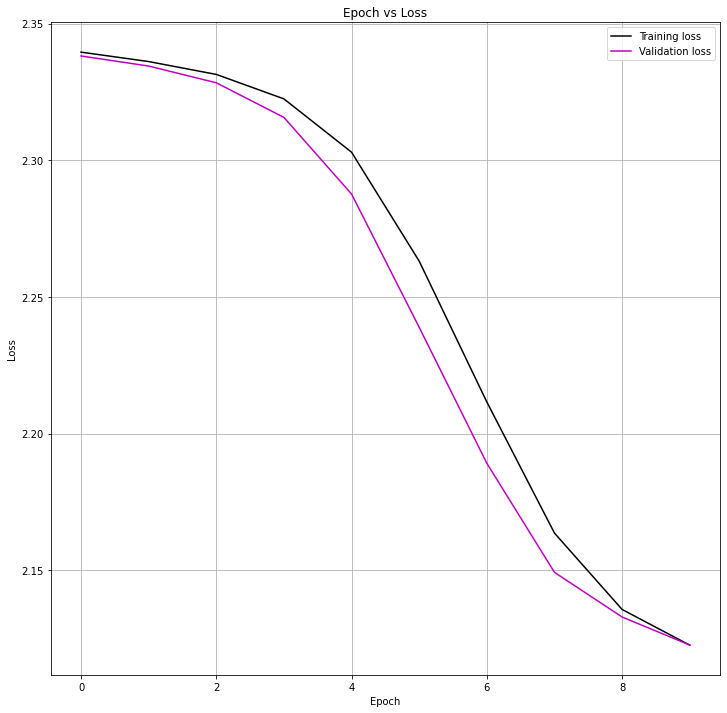

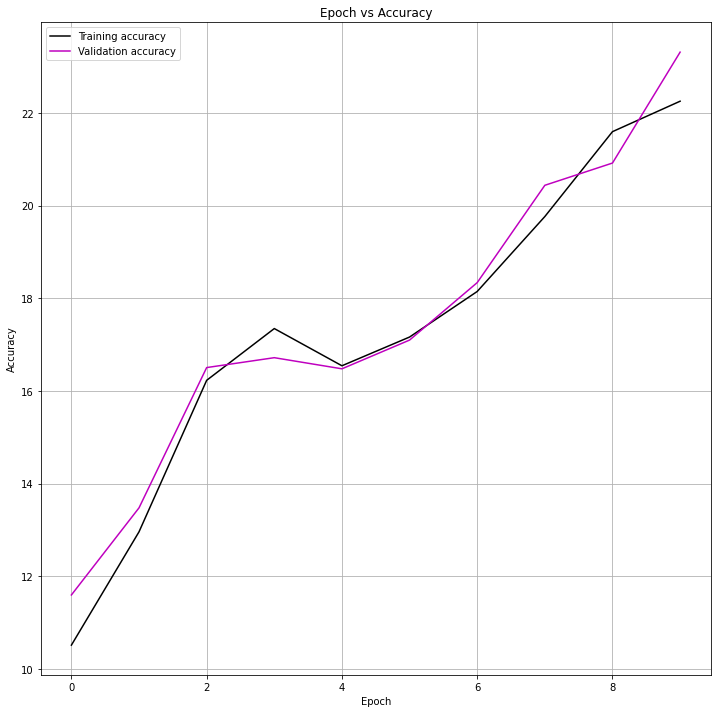



##### Evaluation module #####
Size of test data:  1250
Accuracy:  23.669999999999998
Confusion matrix: 
 Predicted     0    1   2   4    5     6     7     8     9    All
Actual                                                          
0           443   44   9   5    7    47    54   253   138   1000
1           110  216   1   0   36   117   137   207   176   1000
2           140   74  19  13   21   430   144    49   110   1000
3            69  131  11   4   32   338   234    34   147   1000
4            57   66  13   3   16   597   130    34    84   1000
5            49  114  13   2   23   357   231    40   171   1000
6            25   35   6   1    9   679   165     7    73   1000
7            62   86   8   4   22   311   277    24   206   1000
8           288   82   5   3    3    24    51   394   150   1000
9           167  130   0   0    8    79   147   156   313   1000
All        1410  978  85  35  177  2979  1570  1198  1568  10000




/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


In [ ]:
cnn_attention, accuracy, writer = CIFAR10_classifier(experiment_name="CNN_attention",
                                             learning_rate=LEARNING_RATE, 
                                             train_batch_size=TRAIN_BATCH_SIZE, 
                                             patience=PATIENCE, 
                                             activation_function=ACTIVATION_FUNCTION, 
                                             pooling_type=POOLING_TYPE,
                                             num_epochs=NUM_EPOCHS, 
                                             optimizer_class=OPTIMIZER_CLASS, 
                                             weight_decay=WEIGHT_DECAY,
                                             regularization_level=REGULARIZATION_LEVEL,
                                             criterion_class=CRITERION_CLASS,
                                             early_stopping=True,
                                             close_writer=True,
                                             additional_scalar_identifier="_CNN_attention",
                                             model_type="CNN_attention",
                                            )


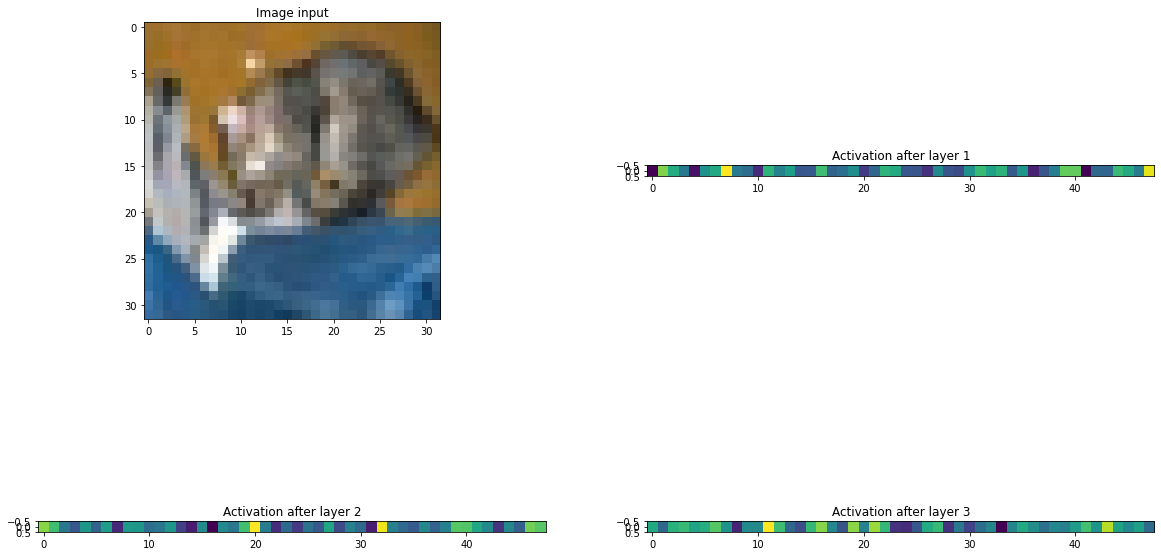

In [82]:
img, label = testset[0]
img_input = img.unsqueeze(0)
out_cnn = cnn_attention(img_input)

plt.figure(figsize=(20, 12))
plt.subplot(221)
img = img / 2 + 0.5     # unnormalize image in range (0, 1)
npimg = img.numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.title('Image input')
plt.subplot(222)
g1 = cnn_attention.g1.detach()
g1 = g1.squeeze(0).numpy()
plt.imshow(g1[np.newaxis])
plt.title('Activation after layer 1')

plt.subplot(223)
g2 = cnn_attention.g2.detach()
g2 = g2.squeeze(0).numpy()
plt.imshow(g2[np.newaxis])
plt.title('Activation after layer 2')

plt.subplot(224)
g3 = cnn_attention.g3.detach()
g3 = g3.squeeze(0).numpy()
plt.imshow(g3[np.newaxis])
plt.title('Activation after layer 3')

plt.show()

# Findings of the experiment
1. The activations shown in the above plots are difficult to interpret and cannot provide any conclusive results unless the activation weights are plotted as a HEATMAP over the input image.
2. The accuracy is very low because the model has more parameters than the other CNNs used in the assignment. This requires relatively higher epochs to train.
2. The major challenge is training the actual model in the stipulated time for the submission. 

# References

[1] Ayoosh Kathuria, 'PyTorch 101, Part 5: Understanding Hooks', PaperspaceBlog, Available at: https://blog.paperspace.com/pytorch-hooks-gradient-clipping-debugging/, Accessed on: 06. 12. 2020.

[2] Utku Ozbulak, 'GitHub: PyTorch CNN Visualizations', Available at: https://github.com/utkuozbulak/pytorch-cnn-visualizations, Accessed on: 06. 12. 2020.

[3] Piotr Bialecki (@Ptrblck_de), 'PyTorch Forums: Visualize feature map', Available at: https://discuss.pytorch.org/t/visualize-feature-map/29597/2, Accessed on: 06. 12. 2020.

[4] CS231n: Convolutional Neural Networks for Visual Recognition, 'Convolutional Neural Networks (CNNs / ConvNets)', Available at: https://cs231n.github.io/convolutional-networks/#convert, Accessed on: 06. 12. 2020.

[5] Jetley, S., Lord, N. A., Lee, N., & Torr, P. H. (2018). Learn to pay attention. arXiv preprint arXiv:1804.02391.

[6] Yiqi Yan, 'GitHub: Learn To Pay Attention', Available at: https://github.com/SaoYan/LearnToPayAttention, Accessed on: 10. 12. 2020.